In [1]:
# To display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import requests
import json
import time
from bech32 import bech32_encode, convertbits

from datetime import datetime
from tqdm import tqdm
from bech32 import bech32_decode, convertbits
from binascii import hexlify

In [3]:
pd.options.display.float_format = "{:.6f}".format

In [4]:
def bech32_to_hex(addr_bech32: str) -> str:
    hrp, data = bech32_decode(addr_bech32)
    if data is None:
        raise ValueError(f"Invalid bech32 address: {addr_bech32}")
    decoded = convertbits(data, 5, 8, False)
    return hexlify(bytes(decoded)).decode()

def safe_bech32_to_hex(addr):
    if pd.isna(addr):
        return None
    try:
        return bech32_to_hex(addr)
    except Exception:
        return None

def hex_to_bech32(addr_hex: str, hrp="addr") -> str:
    """Convert 128-char hex string to bech32 address."""
    data = bytes.fromhex(addr_hex)
    five_bit = convertbits(data, 8, 5)
    return bech32_encode(hrp, five_bit)


def safe_hex_to_bech32(addr_hex: str, hrp="addr") -> str:
    """Convert 128-char hex string to bech32 address with error handling."""
    try:
        data = bytes.fromhex(addr_hex)
        five_bit = convertbits(data, 8, 5)
        return bech32_encode(hrp, five_bit)
    except Exception as e:
        return None  

In [6]:
path = "/home/jovyan/work/New Topic/min_aggregated_holder_df_revised.csv"
min_aggregated_holder_df = pd.read_csv(path)
min_aggregated_holder_df.head()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_min,sent_sum_min,min_balance,ada_balance,received_token_units,sent_token_units,asset_ids,script,received_token_count,sent_token_count,token_num,is_virtual,all_bech32_addresses,has_script_address
0,holder::addr1v82tw68ht75t439kd7k7s8ushvjsm3v25...,136,11324.432640,11129.000000,19.297118,0.000000,19.297118,195.432640,['007394e3117755fbb0558b93c54ce3bc6c8577092004...,[],['007394e3117755fbb0558b93c54ce3bc6c8577092004...,False,822,0,822,True,['addr1v82tw68ht75t439kd7k7s8ushvjsm3v25jerm5e...,False
1,holder::addr1v82v4k5mrcyep87dnhlus24fkaw9eu0zt...,7367,3046999.942683,3045455.047936,8741895.708746,8738219.484971,3676.223775,699.643466,['016be5325fd988fea98ad422fcfd53e5352cacfced5c...,['016be5325fd988fea98ad422fcfd53e5352cacfced5c...,['016be5325fd988fea98ad422fcfd53e5352cacfced5c...,False,18,18,17,True,['addr1v82v4k5mrcyep87dnhlus24fkaw9eu0zt7sfa2r...,False
2,holder::addr1v83p9sf9xnardvpgv053ux7hpf6gdqavn...,3,7.137344,3.376212,14.757021,0.000000,14.757021,3.761132,['29d222ce763455e3d7a09a665ce554f00ac89d2e99a1...,[],['29d222ce763455e3d7a09a665ce554f00ac89d2e99a1...,False,1,0,1,True,['addr1v83p9sf9xnardvpgv053ux7hpf6gdqavn79n66u...,False
3,holder::addr1v85wh6cxs73pl9nanenqlvhzyl62cyeq6...,5,71.954457,60.282977,30.000000,0.000000,30.000000,11.671480,['0445383201b56c4acedf544afa57cb88bfbc616c35b5...,[],['0445383201b56c4acedf544afa57cb88bfbc616c35b5...,False,62,0,62,True,['addr1v85wh6cxs73pl9nanenqlvhzyl62cyeq63x30r0...,False
4,holder::addr1v87m5rn6p4hqcm0622tfccyyexg09hxj8...,946,31488.251885,31289.453271,2378862.897125,2368070.873948,10792.023177,198.798614,['02d5d953cfd8b9163836a8611bc3973297f7e4d29c4f...,['02d5d953cfd8b9163836a8611bc3973297f7e4d29c4f...,['29d222ce763455e3d7a09a665ce554f00ac89d2e99a1...,False,543,543,45,True,['addr1v87m5rn6p4hqcm0622tfccyyexg09hxj8yr2d6e...,False


In [7]:
min_aggregated_holder_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25205 entries, 0 to 25204
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   final_holder_id       25205 non-null  object 
 1   tx_count              25205 non-null  int64  
 2   received_sum_ada      25205 non-null  float64
 3   sent_sum_ada          25205 non-null  float64
 4   received_sum_min      25205 non-null  float64
 5   sent_sum_min          25205 non-null  float64
 6   min_balance           25205 non-null  float64
 7   ada_balance           25205 non-null  float64
 8   received_token_units  25205 non-null  object 
 9   sent_token_units      25205 non-null  object 
 10  asset_ids             25205 non-null  object 
 11  script                25205 non-null  bool   
 12  received_token_count  25205 non-null  int64  
 13  sent_token_count      25205 non-null  int64  
 14  token_num             25205 non-null  int64  
 15  is_virtual         

In [11]:
# Drop the list columns that are no longer needed
cols_to_drop = ["received_token_units", "sent_token_units", "asset_ids", "script"]
min_aggregated_holder_df = min_aggregated_holder_df.drop(columns=[c for c in cols_to_drop if c in min_aggregated_holder_df.columns])

# Preview result
min_aggregated_holder_df.head()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_min,sent_sum_min,min_balance,ada_balance,received_token_count,sent_token_count,token_num,is_virtual,all_bech32_addresses,has_script_address
0,holder::addr1v82tw68ht75t439kd7k7s8ushvjsm3v25...,136,11324.432640,11129.000000,19.297118,0.000000,19.297118,195.432640,822,0,822,True,['addr1v82tw68ht75t439kd7k7s8ushvjsm3v25jerm5e...,False
1,holder::addr1v82v4k5mrcyep87dnhlus24fkaw9eu0zt...,7367,3046999.942683,3045455.047936,8741895.708746,8738219.484971,3676.223775,699.643466,18,18,17,True,['addr1v82v4k5mrcyep87dnhlus24fkaw9eu0zt7sfa2r...,False
2,holder::addr1v83p9sf9xnardvpgv053ux7hpf6gdqavn...,3,7.137344,3.376212,14.757021,0.000000,14.757021,3.761132,1,0,1,True,['addr1v83p9sf9xnardvpgv053ux7hpf6gdqavn79n66u...,False
3,holder::addr1v85wh6cxs73pl9nanenqlvhzyl62cyeq6...,5,71.954457,60.282977,30.000000,0.000000,30.000000,11.671480,62,0,62,True,['addr1v85wh6cxs73pl9nanenqlvhzyl62cyeq63x30r0...,False
4,holder::addr1v87m5rn6p4hqcm0622tfccyyexg09hxj8...,946,31488.251885,31289.453271,2378862.897125,2368070.873948,10792.023177,198.798614,543,543,45,True,['addr1v87m5rn6p4hqcm0622tfccyyexg09hxj8yr2d6e...,False


# Data Cleaning

In [12]:
print(min_aggregated_holder_df["has_script_address"].value_counts())

has_script_address
False    24904
Name: count, dtype: int64


In [13]:
# Count missing values per column
missing_counts = min_aggregated_holder_df.isnull().sum()

# Only show columns that have missing values
missing_counts = missing_counts[missing_counts > 0]

# Show result
if missing_counts.empty:
    print("✅ No missing values found in any column.")
else:
    print("⚠️ Missing values detected:")
    print(missing_counts)


✅ No missing values found in any column.


In [14]:
import ast  # Safely convert string to list

# Step 1: Remove rows where min_balance < 1
filtered_df = min_aggregated_holder_df[min_aggregated_holder_df["min_balance"] >= 1].copy()

# Step 2: Remove rows with any script address
filtered_df = filtered_df[filtered_df["has_script_address"] == False]

# Step 3: Exclude rows where any address in all_bech32_addresses is in exclusion list
exclusion_list = set([
    "addr1z9wdv59sq7zzy2l6gchq3247lz7ssfsxs45nj4njhwsp5uzj2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pqzygnta",
    "addr1q9xq37kqja9pwrvddmf4ss8ckdpqw2y3marghtleh4lr43g6h6eeaatkc5rvs99zueha8v4dm42kmr94dtqkrrlpfafqwag0um",
    "addr1zyh059kj23v37qws877k2lfq2pq950tx34vx6fptfm3caanxj463ndz0rrqzszwrx2mle54c07hwu6kd2w97ae7xlzgqxz4nwc",
    "addr1q9gxe8vx0kvv5g6gv4n5wmsxexjqsjftc599qqcp2vkmmwh7snv5yhw2qqvdev3c7wn6s3xhrnx25eg6zcqjxj9vrv2s0e38ze",
    "addr1q9gxe8vx0kvv5g6gv4n5wmsxexjqsjftc599qqcp2vkmmwh7snv5yhw2qqvdev3c7wn6s3xhrnx25eg6zcqjxj9vrv2s0e38ze",
    "addr1zymeshes0pxnr2s4v95a4wchxs74l0lqt5n3f6rxynnepgjj2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pq64anuz",
    "addr1z87vw6ts32hywu4j4kyk9qfgd36zhzx3y7fc786vgzlc57zj2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pq9rwl7c",
    "addr1z9mjhq5c4s0smv2c92g9yvecpju3p8cfaneu8jzwq97ry62j2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pqw9pw55",
    "addr1zx0wxal6dz7rjzxk2mwfvj9564rp9uajqrscftx44tp6ha6j2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pq83j9cv",
    "addr1vx00uxlpkzgkrga47zdypj40a3yjs0u3wad88kdy9l3rekcrmyz69",
    "addr1w9jk84m6fk5p4yvrr35dry4ramhmqdq0zdq4rz4w0n3dfrsdkkvfe",
    "addr1z87vw6ts32hywu4j4kyk9qfgd36zhzx3y7fc786vgzlc57zj2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pq9rwl7c",
    "addr1z84q0denmyep98ph3tmzwsmw0j7zau9ljmsqx6a4rvaau66j2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pq777e2a",
    "addr1z9wdv59sq7zzy2l6gchq3247lz7ssfsxs45nj4njhwsp5uzj2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pqzygnta",
    "addr1wy3fscaws62d59k6qqhg3xsarx7vstzczgjmdhx2jh7knksj7w3y7",
    "addr1z9v4rd9asfpe8nqh4u34lmud7jgje7nnpe6xtk6nkuhynetxj463ndz0rrqzszwrx2mle54c07hwu6kd2w97ae7xlzgqhpzdvm",
    "addr1z8snz7c4974vzdpxu65ruphl3zjdvtxw8strf2c2tmqnxz2j2c79gy9l76sdg0xwhd7r0c0kna0tycz4y5s6mlenh8pq0xmsha",
    "addr1wypx225nhqe8hfjtds9m3ha3rfmvhven50amgfpamsy9ntq0lhecc"
])


# Function to safely convert to list and check exclusion
def contains_excluded_address(address_str):
    try:
        address_list = ast.literal_eval(address_str)
        return any(addr in exclusion_list for addr in address_list)
    except Exception:
        return False  # If parsing fails, assume not excluded

filtered_df = filtered_df[~filtered_df["all_bech32_addresses"].apply(contains_excluded_address)]

# Overwrite original df
min_aggregated_holder_df = filtered_df

# Report final shape
print(f"✅ Final cleaned min_aggregated_holder_df shape: {min_aggregated_holder_df.shape}")


✅ Final cleaned min_aggregated_holder_df shape: (24904, 14)


# EDA

In [15]:
min_aggregated_holder_df.head()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_min,sent_sum_min,min_balance,ada_balance,received_token_count,sent_token_count,token_num,is_virtual,all_bech32_addresses,has_script_address
0,holder::addr1v82tw68ht75t439kd7k7s8ushvjsm3v25...,136,11324.432640,11129.000000,19.297118,0.000000,19.297118,195.432640,822,0,822,True,['addr1v82tw68ht75t439kd7k7s8ushvjsm3v25jerm5e...,False
1,holder::addr1v82v4k5mrcyep87dnhlus24fkaw9eu0zt...,7367,3046999.942683,3045455.047936,8741895.708746,8738219.484971,3676.223775,699.643466,18,18,17,True,['addr1v82v4k5mrcyep87dnhlus24fkaw9eu0zt7sfa2r...,False
2,holder::addr1v83p9sf9xnardvpgv053ux7hpf6gdqavn...,3,7.137344,3.376212,14.757021,0.000000,14.757021,3.761132,1,0,1,True,['addr1v83p9sf9xnardvpgv053ux7hpf6gdqavn79n66u...,False
3,holder::addr1v85wh6cxs73pl9nanenqlvhzyl62cyeq6...,5,71.954457,60.282977,30.000000,0.000000,30.000000,11.671480,62,0,62,True,['addr1v85wh6cxs73pl9nanenqlvhzyl62cyeq63x30r0...,False
4,holder::addr1v87m5rn6p4hqcm0622tfccyyexg09hxj8...,946,31488.251885,31289.453271,2378862.897125,2368070.873948,10792.023177,198.798614,543,543,45,True,['addr1v87m5rn6p4hqcm0622tfccyyexg09hxj8yr2d6e...,False


In [16]:
# Step 1: Sort the DataFrame by min balance in descending order
top_10_holders = min_aggregated_holder_df.sort_values(by="min_balance", ascending=False).head(10)

# Step 2: Display top 10 holders with their min balances and associated addresses
print("💰 Top 10 min Holders by Balance:\n")
print(top_10_holders[["all_bech32_addresses", "min_balance"]].to_string(index=False))


💰 Top 10 min Holders by Balance:

                                                                                                                                                                                                  all_bech32_addresses     min_balance
['addr1q9arx7suyqsg7jwcj65mdty0cpka22gfltq4xgy2hn4nkgt96wv3m64sqmdp0gv5duh6umep57sw2xset9gqmzqtg8ksft0262', 'addr1qyg6698c8yq83z0kw7rn3z7x5rs4e5wemntxzccvtj7shgt96wv3m64sqmdp0gv5duh6umep57sw2xset9gqmzqtg8kse5ea4d'] 23763044.000000
                                                                                                           ['addr1qyw8elq5zufkmjwzt0uflqav8zwdqame4tq65qaamjk8eszsncsxnss4n5gfuntvxlsmq5upefu7ck2lsq0mmlgvkzqsxaj2xu'] 11990000.000000
                                                                                                           ['addr1q8czwpjfhdxagshqy56mtk4zu8mhevrxcl7ucvlugk8nafnnvjmhktzpry8fhjvlw6h0t5vk9m3h4j0k8z642xlmk3cq72ayj0'] 10999999.996667
                                          

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='min_balance', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of MIN Balance')

Text(0.5, 0, 'MIN Balance')

Text(0, 0.5, 'Frequency')

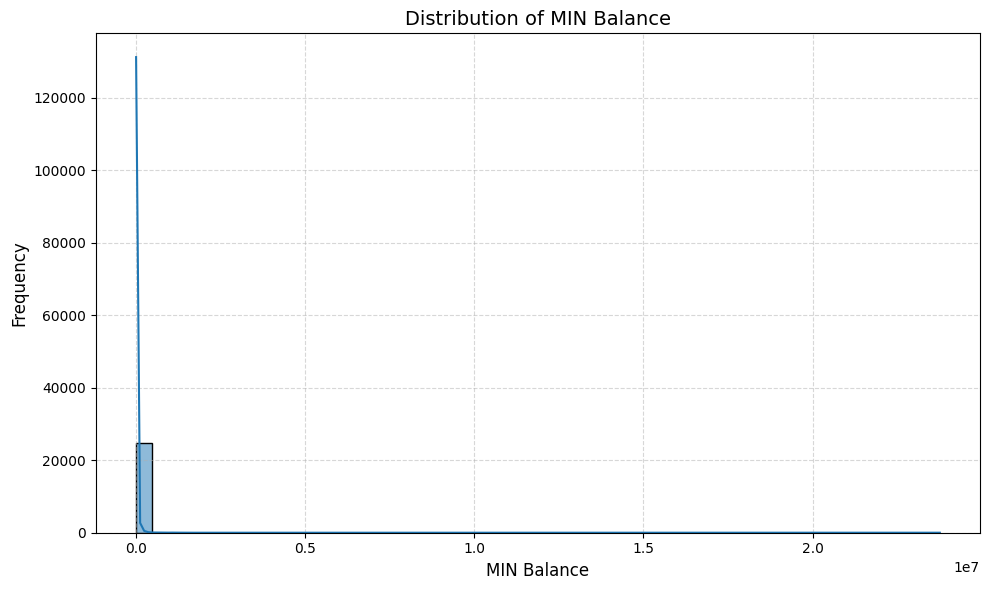

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Plot histogram for min balance ===
plt.figure(figsize=(10, 6))

# Histogram with KDE curve
sns.histplot(min_aggregated_holder_df["min_balance"], bins=50, kde=True)

# Title and labels
plt.title("Distribution of MIN Balance", fontsize=14)
plt.xlabel("MIN Balance", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Lorenz Curve for MIN Balance\nGini Coefficient = 0.947')

Text(0.5, 0, 'Cumulative Share of Addresses')

Text(0, 0.5, 'Cumulative Share of MIN')

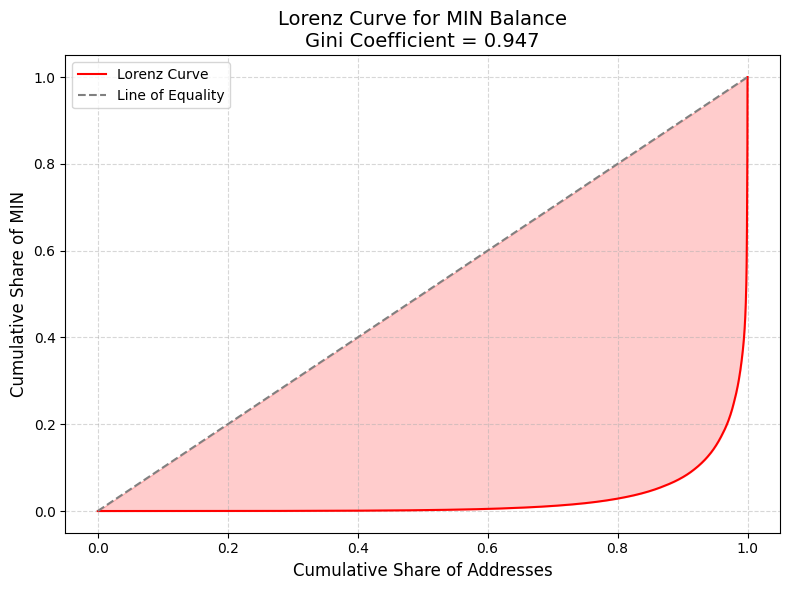

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Sort MIN balances in ascending order ===
balances = min_aggregated_holder_df["min_balance"].sort_values().values
n = len(balances)
cum_balances = np.cumsum(balances)
lorenz_curve = np.insert(cum_balances / cum_balances[-1], 0, 0)  # Normalize and add 0

# === Step 2: Gini calculation ===
x = np.linspace(0.0, 1.0, n+1)
gini_index = 1 - 2 * np.trapz(lorenz_curve, x)

# === Step 3: Plot Lorenz curve ===
plt.figure(figsize=(8, 6))
plt.plot(x, lorenz_curve, label="Lorenz Curve", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Line of Equality")
plt.fill_between(x, lorenz_curve, x, color="red", alpha=0.2)

plt.title(f"Lorenz Curve for MIN Balance\nGini Coefficient = {gini_index:.3f}", fontsize=14)
plt.xlabel("Cumulative Share of Addresses", fontsize=12)
plt.ylabel("Cumulative Share of MIN", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Cumulative Token Share by Top Holders')

Text(0.5, 0, 'Top k Addresses')

Text(0, 0.5, 'Cumulative Share of MIN')

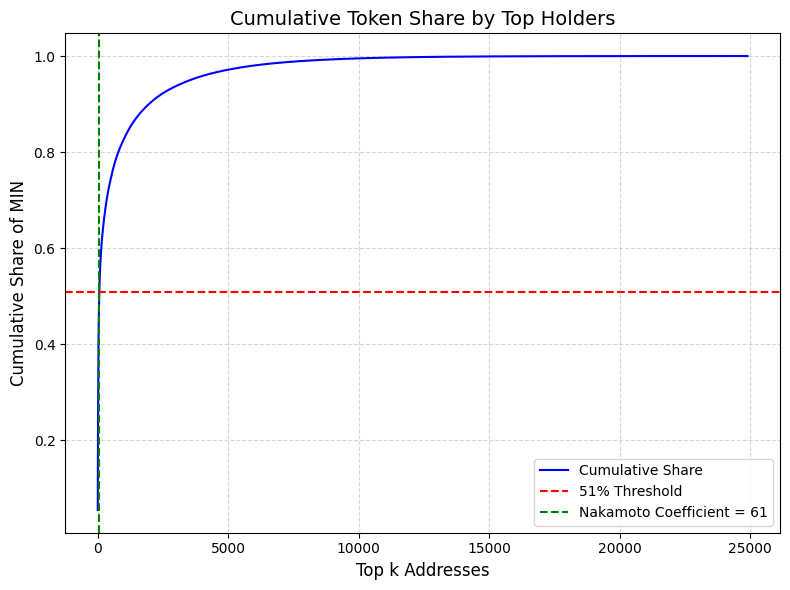

In [19]:
# === Step 1: Sort balances in descending order and normalize ===
sorted_balances = min_aggregated_holder_df["min_balance"].sort_values(ascending=False).values
total = sorted_balances.sum()
shares = sorted_balances / total
cumulative_share = np.cumsum(shares)

# === Step 2: Find minimum k such that cumulative share ≥ 0.51
nakamoto_k = np.argmax(cumulative_share >= 0.51) + 1

# === Step 3: Plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(shares) + 1), cumulative_share, label="Cumulative Share", color="blue")
plt.axhline(0.51, linestyle="--", color="red", label="51% Threshold")
plt.axvline(nakamoto_k, linestyle="--", color="green", label=f"Nakamoto Coefficient = {nakamoto_k}")

plt.title("Cumulative Token Share by Top Holders", fontsize=14)
plt.xlabel("Top k Addresses", fontsize=12)
plt.ylabel("Cumulative Share of MIN", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Token Distribution: Lorenz Curve & Nakamoto Coefficient')

Text(0.5, 0, 'Cumulative Share of Addresses')

Text(0, 0.5, 'Cumulative Share of MIN')

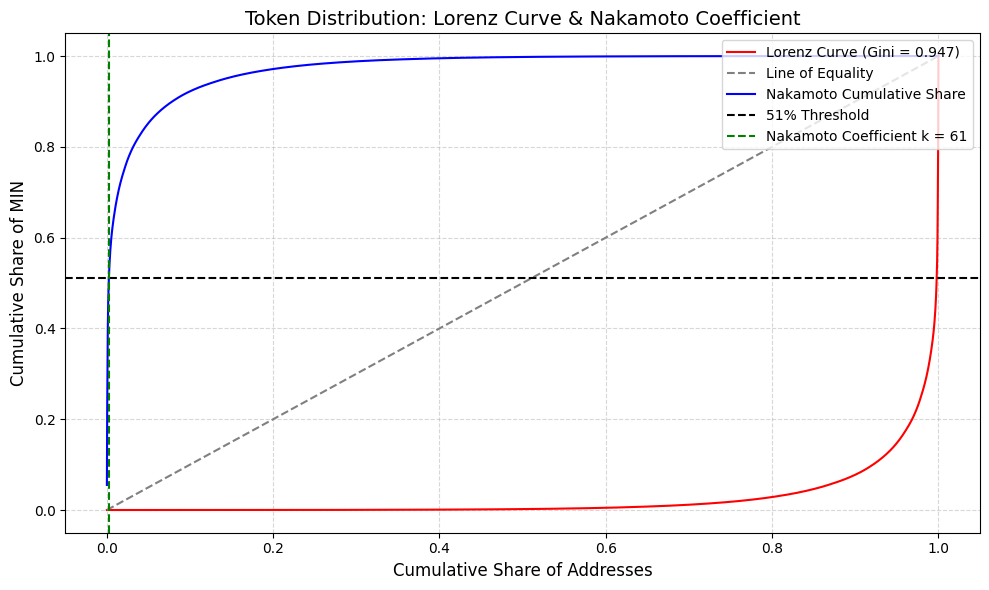

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Lorenz Curve (Gini) ===
balances = min_aggregated_holder_df["min_balance"].sort_values().values
n = len(balances)
cum_balances = np.cumsum(balances)
lorenz_curve = np.insert(cum_balances / cum_balances[-1], 0, 0)
x_lorenz = np.linspace(0.0, 1.0, n + 1)
gini_index = 1 - 2 * np.trapz(lorenz_curve, x_lorenz)

# === Step 2: Nakamoto Coefficient ===
sorted_balances_desc = min_aggregated_holder_df["min_balance"].sort_values(ascending=False).values
total = sorted_balances_desc.sum()
shares = sorted_balances_desc / total
cumulative_share = np.cumsum(shares)
x_nakamoto = np.arange(1, len(shares) + 1)
nakamoto_k = np.argmax(cumulative_share >= 0.51) + 1

# === Step 3: Plot combined figure ===
plt.figure(figsize=(10, 6))

# Lorenz curve
plt.plot(x_lorenz, lorenz_curve, label=f"Lorenz Curve (Gini = {gini_index:.3f})", color="red")

# Line of equality
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Line of Equality")

# Nakamoto cumulative
plt.plot(x_nakamoto / len(shares), cumulative_share, label="Nakamoto Cumulative Share", color="blue")

# Thresholds
plt.axhline(0.51, linestyle="--", color="black", label="51% Threshold")
plt.axvline(nakamoto_k / len(shares), linestyle="--", color="green", label=f"Nakamoto Coefficient k = {nakamoto_k}")

# Titles & labels
plt.title("Token Distribution: Lorenz Curve & Nakamoto Coefficient", fontsize=14)
plt.xlabel("Cumulative Share of Addresses", fontsize=12)
plt.ylabel("Cumulative Share of MIN", fontsize=12)

# Updated legend position
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

# Step 1: Sort by MIN balance in descending order
sorted_min = min_aggregated_holder_df.sort_values(by="min_balance", ascending=False)

# Step 2: Compute MIN share per address
total_min = sorted_min["min_balance"].sum()
sorted_min["min_share"] = sorted_min["min_balance"] / total_min

# Step 3: Compute cumulative share
sorted_min["cumulative_share"] = sorted_min["min_share"].cumsum()

# ✅ Step 4: Get true Nakamoto k (smallest number of top addresses reaching ≥ 51%)
nakamoto_k = (sorted_min["cumulative_share"] >= 0.51).values.argmax() + 1

print(f"🔐 Corrected Nakamoto coefficient k = {nakamoto_k}")


🔐 Corrected Nakamoto coefficient k = 61


In [22]:
# Sort by MIN balance in descending order
sorted_df = min_aggregated_holder_df.sort_values(by="min_balance", ascending=False)

# Get the top 100 holders
top_100_df = sorted_df.head(100)

# Calculate total MIN held by top 100
top_100_total = top_100_df["min_balance"].sum()

# Calculate total MIN in the dataset
total_min = min_aggregated_holder_df["min_balance"].sum()

# Calculate the percentage
top_100_share = top_100_total / total_min * 100

# Display the result
print(f"🔝 Top 100 holders hold {top_100_share:.2f}% of total MIN")


🔝 Top 100 holders hold 56.82% of total MIN


In [23]:
from pandas.api.types import CategoricalDtype

# Refined bin edges and ordered labels
bins = [1, 10, 50, 100, 500, 1_000, 10_000, 100_000, 1_000_000, float('inf')]
labels = ['1–10', '10–50', '50–100', '100–500', '500–1k', '1k–10k', '10k–100k', '100k–1M', '≥1M']

# Define ordered category
ordered_cat = CategoricalDtype(categories=labels, ordered=True)

# Assign tier to each address based on MIN balance
min_aggregated_holder_df["min_tier"] = pd.cut(
    min_aggregated_holder_df["min_balance"],
    bins=bins,
    labels=labels,
    right=False
).astype(ordered_cat)

# Aggregate data by tier
distribution = min_aggregated_holder_df.groupby("min_tier").agg(
    address_count=("final_holder_id", "count"),
    total_min=("min_balance", "sum")
).reset_index()

# Compute shares
total_addresses = distribution["address_count"].sum()
total_min = distribution["total_min"].sum()
distribution["% of addresses"] = distribution["address_count"] / total_addresses * 100
distribution["% of total MIN"] = distribution["total_min"] / total_min * 100

# Format
distribution["total_min"] = distribution["total_min"].round(0).astype(int)
distribution["% of addresses"] = distribution["% of addresses"].round(2)
distribution["% of total MIN"] = distribution["% of total MIN"].round(2)

distribution


/tmp/ipykernel_9305/132348958.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribution = min_aggregated_holder_df.groupby("min_tier").agg(


,min_tier,address_count,total_min,% of addresses,% of total MIN
0,1–10,2916,11992,11.710000,0.000000
1,10–50,4161,108718,16.710000,0.030000
2,50–100,1959,139058,7.870000,0.030000
3,100–500,4740,1142041,19.030000,0.270000
4,500–1k,1894,1337086,7.610000,0.310000
5,1k–10k,5909,20764222,23.730000,4.830000
6,10k–100k,2768,80441709,11.110000,18.720000
7,100k–1M,498,108476892,2.000000,25.240000
8,≥1M,59,217397576,0.240000,50.580000


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='min_balance', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Holders with 1 to 1000 MIN')

Text(0.5, 0, 'MIN Balance')

Text(0, 0.5, 'Number of Holders')

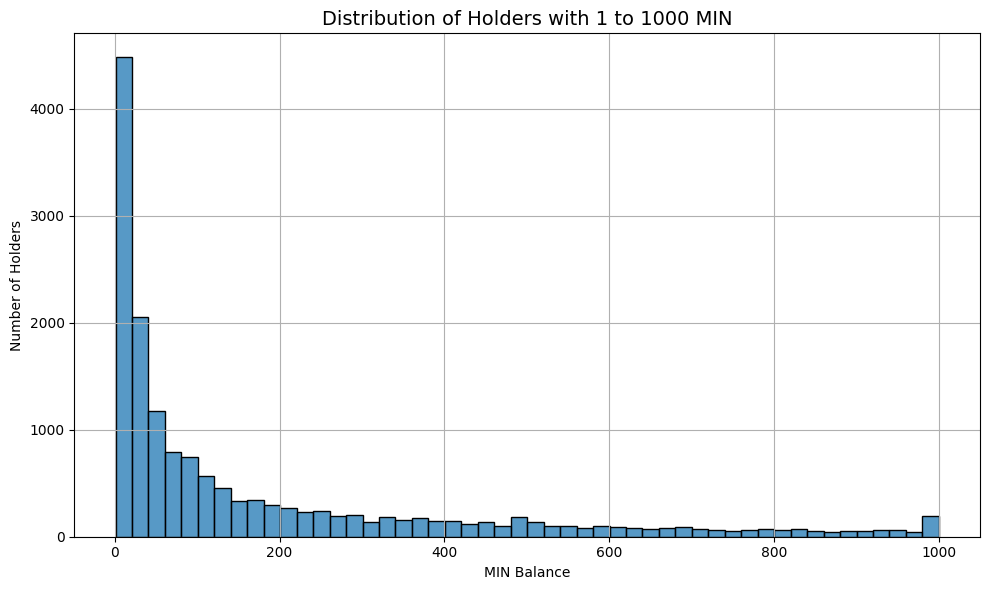

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter holders with 1 ≤ min_balance ≤ 1000
filtered = min_aggregated_holder_df[
    (min_aggregated_holder_df["min_balance"] >= 1) &
    (min_aggregated_holder_df["min_balance"] <= 1000)
]

# Step 2: Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered["min_balance"], bins=50, kde=False)
plt.title("Distribution of Holders with 1 to 1000 MIN", fontsize=14)
plt.xlabel("MIN Balance")
plt.ylabel("Number of Holders")
plt.grid(True)
plt.tight_layout()
plt.show()


# Deal With Skewness

In [20]:
min_aggregated_holder_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24904 entries, 0 to 25204
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   final_holder_id       24904 non-null  object  
 1   tx_count              24904 non-null  int64   
 2   received_sum_ada      24904 non-null  float64 
 3   sent_sum_ada          24904 non-null  float64 
 4   received_sum_gens     24904 non-null  float64 
 5   sent_sum_gens         24904 non-null  float64 
 6   received_sum_milk     24904 non-null  float64 
 7   sent_sum_milk         24904 non-null  float64 
 8   received_sum_min      24904 non-null  float64 
 9   sent_sum_min          24904 non-null  float64 
 10  received_sum_wrt      24904 non-null  float64 
 11  sent_sum_wrt          24904 non-null  float64 
 12  received_sum_sundae   24904 non-null  float64 
 13  sent_sum_sundae       24904 non-null  float64 
 14  received_token_count  24904 non-null  int64   
 15  sent_to

<Axes: xlabel='tx_count', ylabel='Count'>

Text(0.5, 1.0, 'tx_count\nSkew: 74.52')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_sum_ada', ylabel='Count'>

Text(0.5, 1.0, 'received_sum_ada\nSkew: 109.83')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_sum_ada', ylabel='Count'>

Text(0.5, 1.0, 'sent_sum_ada\nSkew: 105.61')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_sum_min', ylabel='Count'>

Text(0.5, 1.0, 'received_sum_min\nSkew: 92.29')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_sum_min', ylabel='Count'>

Text(0.5, 1.0, 'sent_sum_min\nSkew: 92.49')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='min_balance', ylabel='Count'>

Text(0.5, 1.0, 'min_balance\nSkew: 50.22')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='ada_balance', ylabel='Count'>

Text(0.5, 1.0, 'ada_balance\nSkew: 157.75')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_token_count', ylabel='Count'>

Text(0.5, 1.0, 'received_token_count\nSkew: 87.79')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_token_count', ylabel='Count'>

Text(0.5, 1.0, 'sent_token_count\nSkew: 9.51')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='token_num', ylabel='Count'>

Text(0.5, 1.0, 'token_num\nSkew: 116.46')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.02, 'Distribution of Numeric Variables with Skewness')

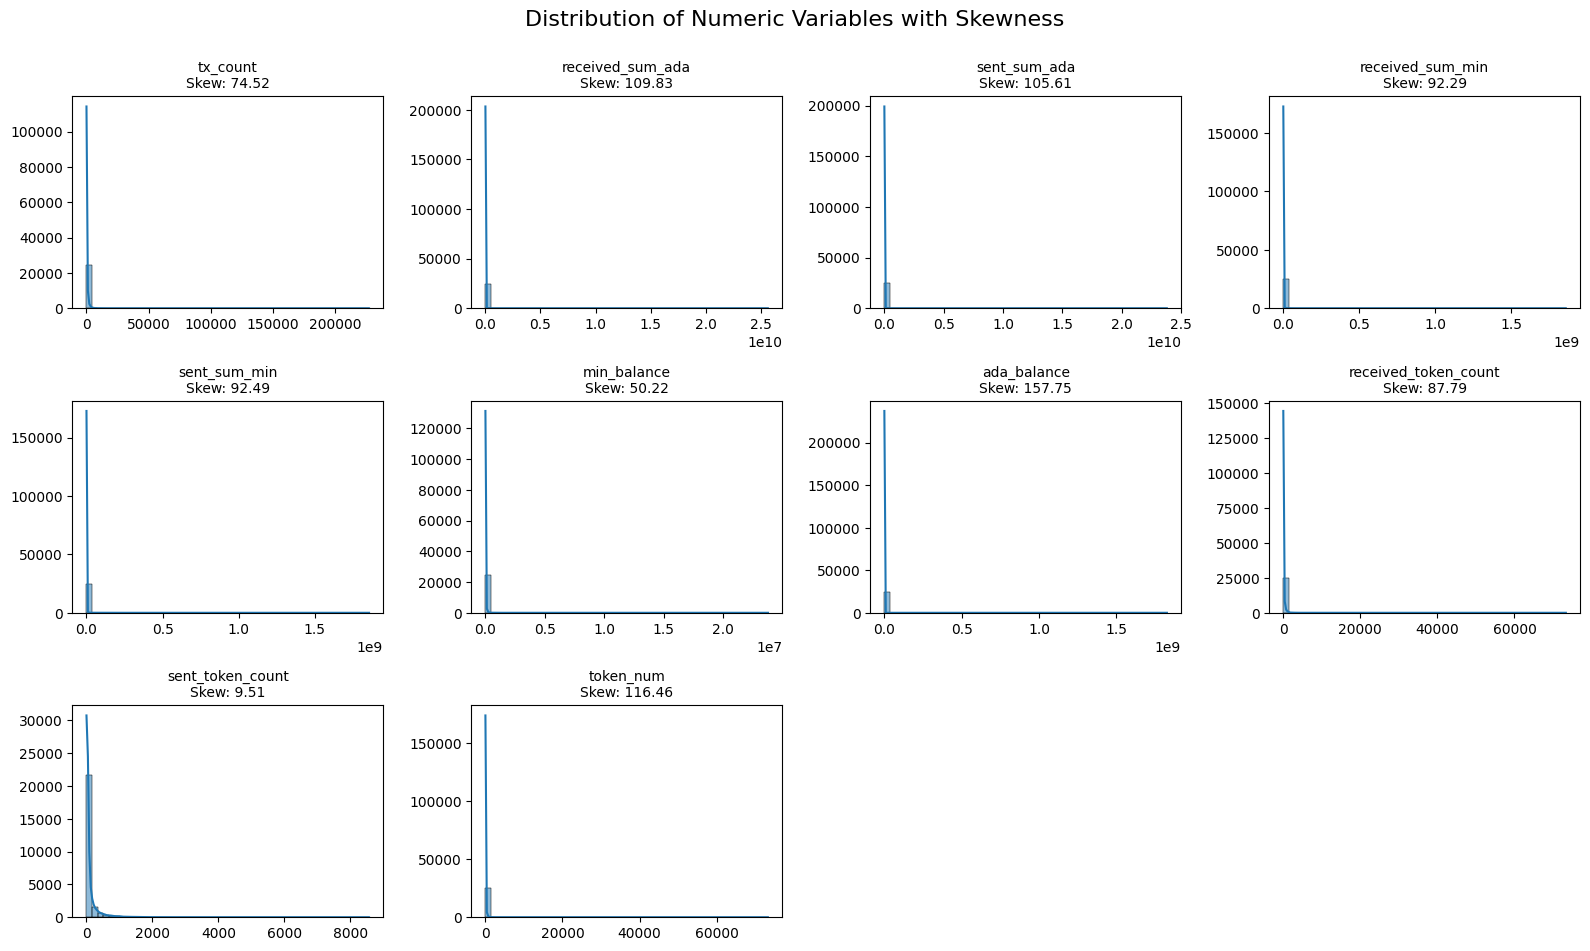

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Step 1: Get numeric columns (excluding addresses)
exclude_cols = [
    "final_holder_id", "hex_address", "is_virtual", "bech32_address", "all_bech32_addresses", "has_script_address", "min_tier"]
numeric_cols = [col for col in min_aggregated_holder_df.columns if col not in exclude_cols]

# Step 2: Compute skewness safely
skewness_values = {}
for col in numeric_cols:
    try:
        skewness_values[col] = skew(min_aggregated_holder_df[col].dropna())
    except Exception as e:
        print(f"⚠️ Skewness failed for {col}: {e}")
        skewness_values[col] = None

# Step 3: Set up 6x4 subplot grid
num_plots = len(numeric_cols)
num_rows, num_cols = 6, 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
axes = axes.flatten()  # Make it 1D for easy indexing

# Step 4: Plot each histogram in its subplot
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    try:
        sns.histplot(min_aggregated_holder_df[col], bins=50, kde=True, ax=ax)
        ax.set_title(f"{col}\nSkew: {skewness_values[col]:.2f}", fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("")
    except Exception as e:
        ax.text(0.5, 0.5, f"Failed: {col}", ha='center', va='center')
        print(f"❌ Failed to plot {col}: {e}")

# Step 5: Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution of Numeric Variables with Skewness", fontsize=16, y=1.02)
plt.show()
plt.close()


In [26]:
from sklearn.preprocessing import PowerTransformer

# List of highly skewed variables you want to transform
highly_skewed_cols = [
    "sent_sum_min", "received_sum_min",
    "sent_sum_ada", "received_sum_ada",
    "token_num", "ada_balance",
    "tx_count", "min_balance",
     "received_token_count", "sent_token_count"
]

# Transform each column independently (safer/clearer)
for col in highly_skewed_cols:
    x = min_aggregated_holder_df[col].to_numpy(dtype=float)
    mask = np.isfinite(x)  # handle NaN/inf safely

    pt = PowerTransformer(method="yeo-johnson", standardize=False)
    x_out = np.full_like(x, np.nan, dtype=float)
    if mask.any():
        x_out[mask] = pt.fit_transform(x[mask].reshape(-1, 1)).ravel()

    min_aggregated_holder_df[f"{col}_yeojohnson"] = x_out


<Axes: xlabel='sent_sum_min_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'sent_sum_min_yeojohnson\nSkew: -0.03')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_sum_min_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'received_sum_min_yeojohnson\nSkew: 0.00')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_sum_ada_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'sent_sum_ada_yeojohnson\nSkew: -0.02')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_sum_ada_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'received_sum_ada_yeojohnson\nSkew: -0.01')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='token_num_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'token_num_yeojohnson\nSkew: 0.11')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='ada_balance_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'ada_balance_yeojohnson\nSkew: 0.13')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='tx_count_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'tx_count_yeojohnson\nSkew: 0.01')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='min_balance_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'min_balance_yeojohnson\nSkew: 0.02')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='received_token_count_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'received_token_count_yeojohnson\nSkew: 0.08')

Text(0.5, 0, '')

Text(0, 0.5, '')

<Axes: xlabel='sent_token_count_yeojohnson', ylabel='Count'>

Text(0.5, 1.0, 'sent_token_count_yeojohnson\nSkew: 0.06')

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 1.02, 'All Variables After Yeo–Johnson Transform (incl. counts)')

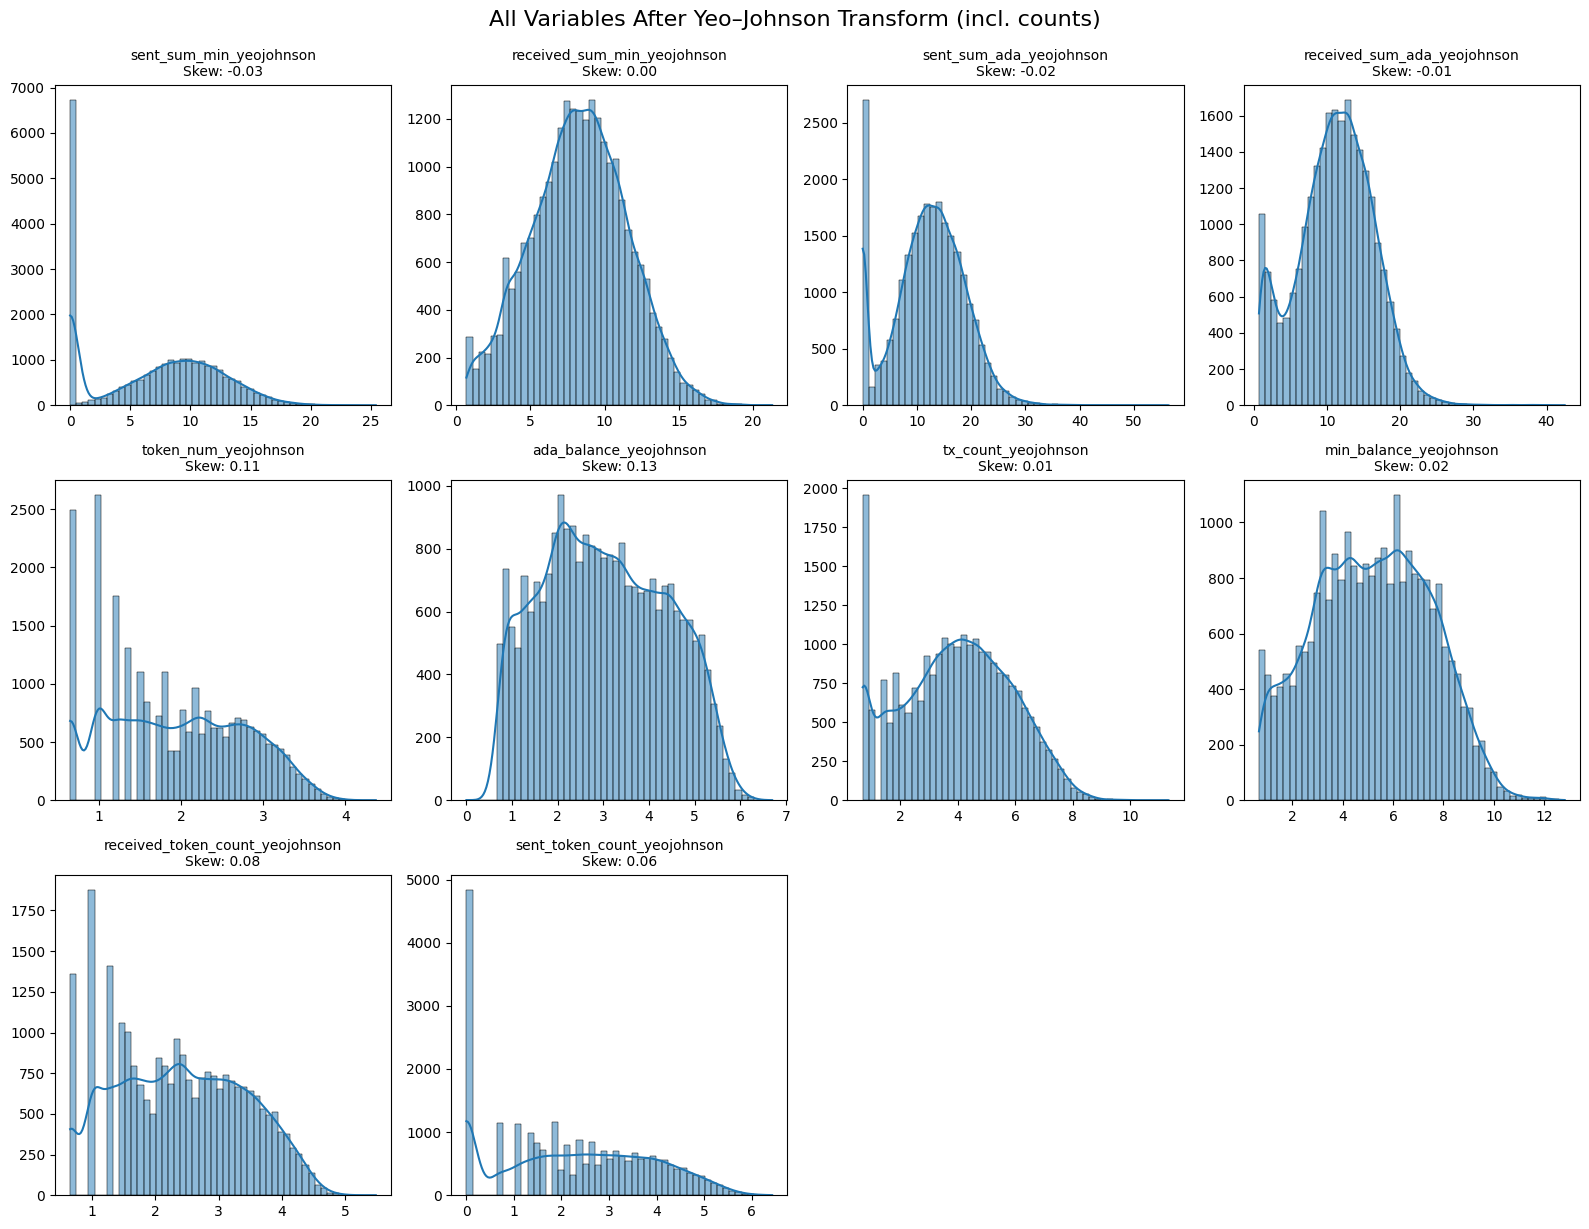

In [27]:
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

# Base variable names (original columns)
vars_base = [
    "sent_sum_min", "received_sum_min",
    "sent_sum_ada", "received_sum_ada",
    "token_num", "ada_balance",
    "tx_count", "min_balance",
    "received_token_count", "sent_token_count"
]

# Corresponding transformed columns
vars_yj = [f"{c}_yeojohnson" for c in vars_base]

# Check for available and non-empty columns
valid_vars = [c for c in vars_yj if c in min_aggregated_holder_df.columns and not min_aggregated_holder_df[c].dropna().empty]
if not valid_vars:
    print("❗ No valid variables to plot.")
else:
    # Compute skewness based on transformed data
    skewness_values = {}
    for col in valid_vars:
        try:
            skewness_values[col] = skew(min_aggregated_holder_df[col].dropna())
        except Exception as e:
            print(f"⚠️ Skewness failed for {col}: {e}")
            skewness_values[col] = None

    # Create subplots for histograms
    rows, cols = 3, 4
    fig2, axes2 = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 12))
    axes2 = axes2.flatten()

    # Plot each variable distribution
    for i, col in enumerate(valid_vars):
        ax = axes2[i]
        try:
            sns.histplot(min_aggregated_holder_df[col], bins=50, kde=True, ax=ax)
            sk = skewness_values.get(col)
            ax.set_title(f"{col}\nSkew: {sk:.2f}" if sk is not None else f"{col}\nSkew: N/A", fontsize=10)
            ax.set_xlabel("")
            ax.set_ylabel("")
        except Exception as e:
            ax.text(0.5, 0.5, f"Failed: {col}", ha='center', va='center')
            print(f"❌ Failed to plot {col}: {e}")

    # Remove unused subplot axes
    for j in range(len(valid_vars), len(axes2)):
        fig2.delaxes(axes2[j])

    plt.tight_layout()
    plt.suptitle("All Variables After Yeo–Johnson Transform (incl. counts)", fontsize=16, y=1.02)
    plt.show()


In [28]:
features = [
    "sent_sum_min_yeojohnson", "received_sum_min_yeojohnson",
    "sent_sum_ada_yeojohnson", "received_sum_ada_yeojohnson",
    "ada_balance_yeojohnson", "token_num_yeojohnson",
    "tx_count_yeojohnson", "min_balance_yeojohnson",
    "received_token_count_yeojohnson", "sent_token_count_yeojohnson"
]


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Between Features')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'sent_sum_min_yeojohnson'),
  Text(1.5, 0, 'received_sum_min_yeojohnson'),
  Text(2.5, 0, 'sent_sum_ada_yeojohnson'),
  Text(3.5, 0, 'received_sum_ada_yeojohnson'),
  Text(4.5, 0, 'ada_balance_yeojohnson'),
  Text(5.5, 0, 'token_num_yeojohnson'),
  Text(6.5, 0, 'tx_count_yeojohnson'),
  Text(7.5, 0, 'min_balance_yeojohnson'),
  Text(8.5, 0, 'received_token_count_yeojohnson'),
  Text(9.5, 0, 'sent_token_count_yeojohnson')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'sent_sum_min_yeojohnson'),
  Text(0, 1.5, 'received_sum_min_yeojohnson'),
  Text(0, 2.5, 'sent_sum_ada_yeojohnson'),
  Text(0, 3.5, 'received_sum_ada_yeojohnson'),
  Text(0, 4.5, 'ada_balance_yeojohnson'),
  Text(0, 5.5, 'token_num_yeojohnson'),
  Text(0, 6.5, 'tx_count_yeojohnson'),
  Text(0, 7.5, 'min_balance_yeojohnson'),
  Text(0, 8.5, 'received_token_count_yeojohnson'),
  Text(0, 9.5, 'sent_token_count_yeojohnson')])

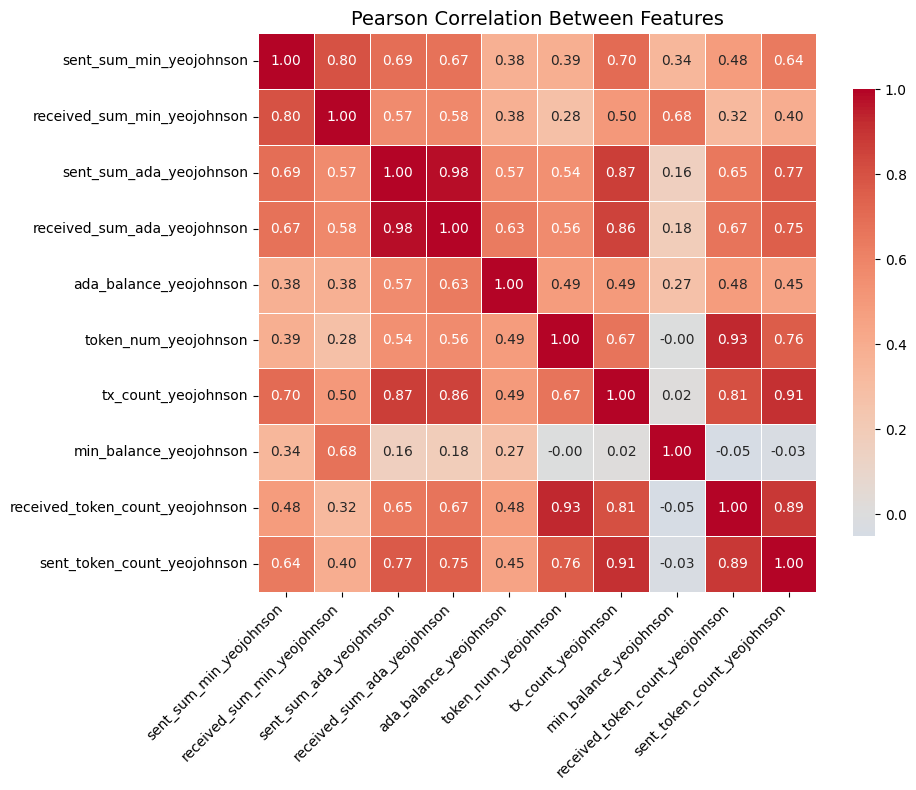

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = min_aggregated_holder_df[features].corr(method='pearson')


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

plt.title("Pearson Correlation Between Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [30]:
features = [
    "sent_sum_min_yeojohnson", 
    "sent_sum_ada_yeojohnson", 
    "ada_balance_yeojohnson", "token_num_yeojohnson",
"min_balance_yeojohnson"
]


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Between Features')

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'sent_sum_min_yeojohnson'),
  Text(1.5, 0, 'sent_sum_ada_yeojohnson'),
  Text(2.5, 0, 'ada_balance_yeojohnson'),
  Text(3.5, 0, 'token_num_yeojohnson'),
  Text(4.5, 0, 'min_balance_yeojohnson')])

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'sent_sum_min_yeojohnson'),
  Text(0, 1.5, 'sent_sum_ada_yeojohnson'),
  Text(0, 2.5, 'ada_balance_yeojohnson'),
  Text(0, 3.5, 'token_num_yeojohnson'),
  Text(0, 4.5, 'min_balance_yeojohnson')])

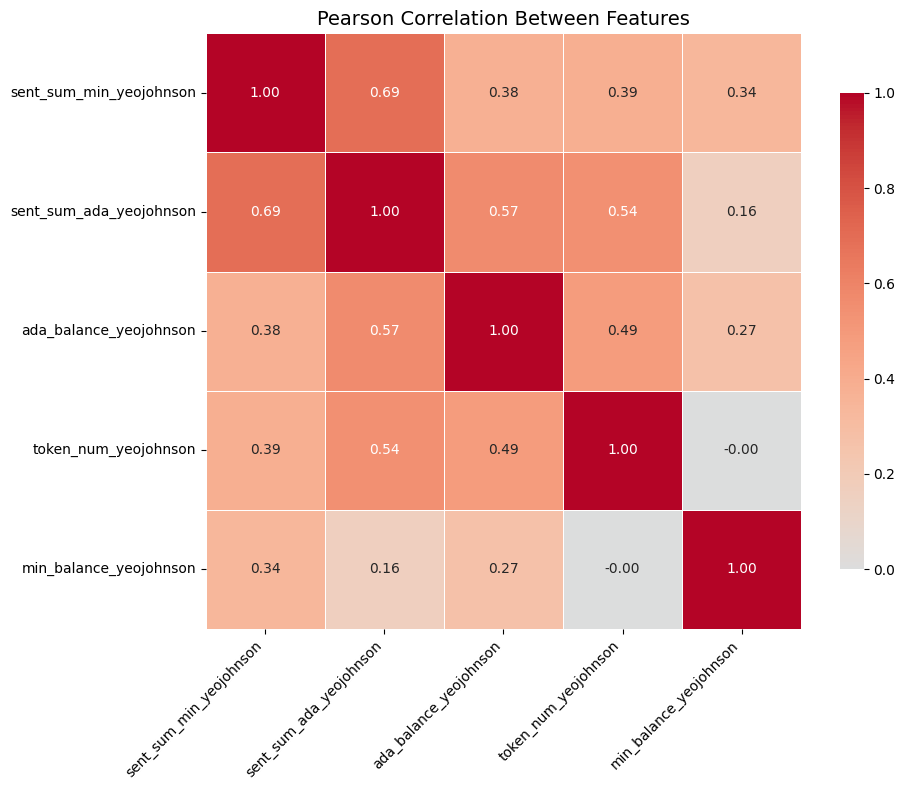

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = min_aggregated_holder_df[features].corr(method='pearson')


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

plt.title("Pearson Correlation Between Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# K-Means Clustering

Text(0.5, 1.0, 'Elbow Method (Inertia vs. k)')

Text(0.5, 0, 'Number of Clusters (k)')

Text(0, 0.5, 'Inertia')

Text(0.5, 1.0, 'Silhouette Score vs. k')

Text(0.5, 0, 'Number of Clusters (k)')

Text(0, 0.5, 'Silhouette Score')

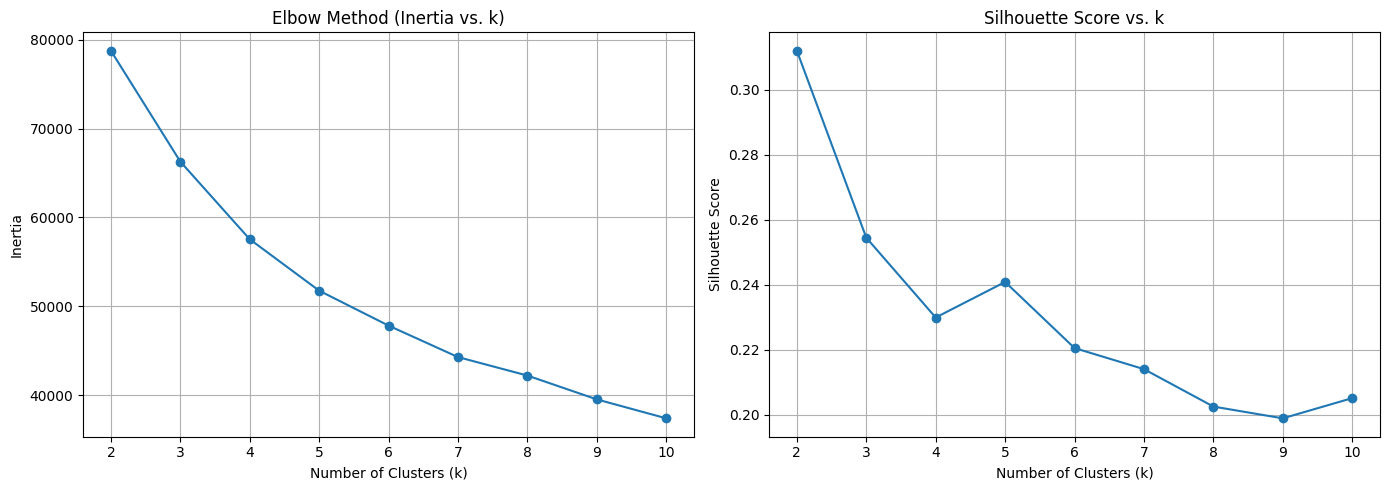

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 1: Extract and standardize the selected features
X = min_aggregated_holder_df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Initialize result containers
inertias = []
silhouette_scores = []
k_range = range(2, 11)  # Try k from 2 to 10

# Step 3: Loop over possible k values to evaluate clustering quality
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)

    # Inertia measures how compact the clusters are (lower = better)
    inertias.append(kmeans.inertia_)

    # Silhouette score measures how well clusters are separated (higher = better)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Step 4: Plot Elbow and Silhouette charts side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Plot: Inertia vs. k
ax1.plot(k_range, inertias, marker='o')
ax1.set_title("Elbow Method (Inertia vs. k)")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.grid(True)

# Silhouette Plot: Silhouette Score vs. k
ax2.plot(k_range, silhouette_scores, marker='o')
ax2.set_title("Silhouette Score vs. k")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.grid(True)

plt.tight_layout()
plt.show()


In [35]:
from sklearn.cluster import KMeans

# Step 1: Fit KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(X_scaled)

# Step 2: Save cluster labels into the dataframe
min_aggregated_holder_df["kmeans_cluster"] = kmeans_labels

# Step 3: Print cluster size counts
print(min_aggregated_holder_df["kmeans_cluster"].value_counts().sort_index())


kmeans_cluster
0    5891
1    6485
2    6947
3    5581
Name: count, dtype: int64


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

Text(0.5, 1.0, 't-SNE Visualization of KMeans Clusters (5D Features)')

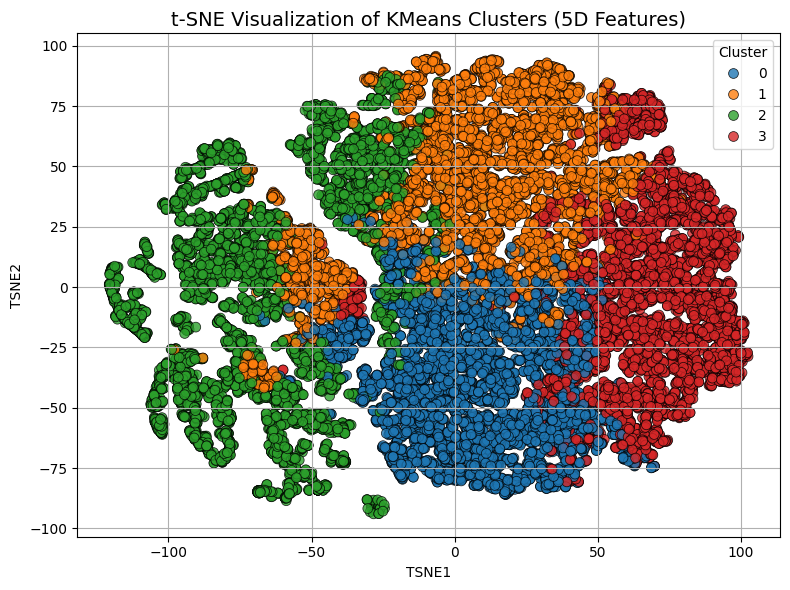

In [36]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Run t-SNE on standardized features
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Step 2: Create a DataFrame for visualization
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["cluster"] = kmeans_labels  # make sure this is from k=4

# Step 3: Plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1", y="TSNE2",
    hue="cluster",
    palette="tab10",
    s=50,
    edgecolor="k",
    alpha=0.8
)
plt.title("t-SNE Visualization of KMeans Clusters (5D Features)", fontsize=14)
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()



In [37]:
cluster_summary = min_aggregated_holder_df.groupby("kmeans_cluster")[features].mean().round(2)
cluster_summary


,sent_sum_min_yeojohnson,sent_sum_ada_yeojohnson,ada_balance_yeojohnson,token_num_yeojohnson,min_balance_yeojohnson
kmeans_cluster,,,,,
0,7.640000,15.790000,3.420000,2.640000,3.250000
1,7.780000,11.150000,2.950000,1.470000,6.340000
2,1.450000,4.740000,1.770000,1.290000,4.060000
3,12.450000,18.410000,4.290000,2.560000,7.250000


In [38]:

X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=min_aggregated_holder_df.index)
X_scaled_df["kmeans_cluster"] = kmeans_labels


cluster_means_std = X_scaled_df.groupby("kmeans_cluster")[features].mean().round(2)
cluster_means_std


,sent_sum_min_yeojohnson,sent_sum_ada_yeojohnson,ada_balance_yeojohnson,token_num_yeojohnson,min_balance_yeojohnson
kmeans_cluster,,,,,
0,0.120000,0.560000,0.290000,0.840000,-0.840000
1,0.140000,-0.140000,-0.060000,-0.570000,0.510000
2,-1.060000,-1.100000,-0.950000,-0.790000,-0.490000
3,1.030000,0.950000,0.950000,0.750000,0.910000


In [39]:
#vars_to_avg = [
#    "sent_sum_min", "received_sum_min",
#    "sent_sum_ada", "received_sum_ada",
#    "token_num", "ada_balance",
#    "tx_count", "min_balance",
#    "received_token_count", "sent_token_count"
#]

vars_to_avg = [
    "sent_sum_min", 
    "sent_sum_ada",
    "token_num", "ada_balance",
    "min_balance",
]


cluster_means = min_aggregated_holder_df.groupby("kmeans_cluster")[vars_to_avg].mean()


cluster_means = cluster_means.round(2)


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

cluster_means


,sent_sum_min,sent_sum_ada,token_num,ada_balance,min_balance
kmeans_cluster,,,,,
0,87245.000000,4402935.450000,119.990000,4362.450000,107.760000
1,53633.870000,24064.930000,7.450000,1170.260000,20921.140000
2,245.010000,2512.050000,7.960000,144.080000,4505.740000
3,2097170.330000,9259251.400000,122.520000,353604.260000,46982.530000


In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

radar_table = cluster_scaled_df.round(2)
radar_table


,sent_sum_min_yeojohnson,sent_sum_ada_yeojohnson,ada_balance_yeojohnson,token_num_yeojohnson,min_balance_yeojohnson
gmm_cluster,,,,,
0,0.680000,0.580000,0.020000,0.000000,0.000000
1,0.930000,0.570000,0.240000,0.430000,1.000000
2,0.000000,0.000000,0.000000,0.220000,0.410000
3,1.000000,1.000000,1.000000,0.600000,0.390000
4,0.960000,0.750000,0.920000,0.640000,1.000000
5,0.000000,0.440000,0.260000,0.200000,0.630000
6,0.890000,0.820000,0.410000,1.000000,0.090000


In [62]:

# Step 1: Create DataFrame from standardized features used in K-means
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=min_aggregated_holder_df.index)
X_scaled_df["kmeans_cluster"] = kmeans_labels

# Step 2: Compute cluster-wise means (in standardized space)
cluster_means_std = X_scaled_df.groupby("kmeans_cluster")[features].mean()

# Step 3: Apply MinMax scaling (0-1 range) for radar chart visualization
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_means_std)
radar_table = pd.DataFrame(cluster_scaled, columns=features, index=cluster_means_std.index).round(2)

# Print the table used for the radar chart
print("Radar chart data (scaled means 0-1):")
radar_table



Radar chart data (scaled means 0-1):


,sent_sum_min_yeojohnson,sent_sum_ada_yeojohnson,ada_balance_yeojohnson,token_num_yeojohnson,min_balance_yeojohnson
kmeans_cluster,,,,,
0,0.560000,0.810000,0.650000,1.000000,0.000000
1,0.570000,0.470000,0.470000,0.140000,0.770000
2,0.000000,0.000000,0.000000,0.000000,0.200000
3,1.000000,1.000000,1.000000,0.940000,1.000000


Text(0.5, 1.0, 'Radar Chart of KMeans Clusters (Model Space)')

(<a list of 10 Line2D ticklines objects>,
 [Text(0.0, 0, 'sent_sum_min_yeojohnson'),
  Text(1.2566370614359172, 0, 'sent_sum_ada_yeojohnson'),
  Text(2.5132741228718345, 0, 'ada_balance_yeojohnson'),
  Text(3.7699111843077517, 0, 'token_num_yeojohnson'),
  Text(5.026548245743669, 0, 'min_balance_yeojohnson')])

(0.0, 1.0)

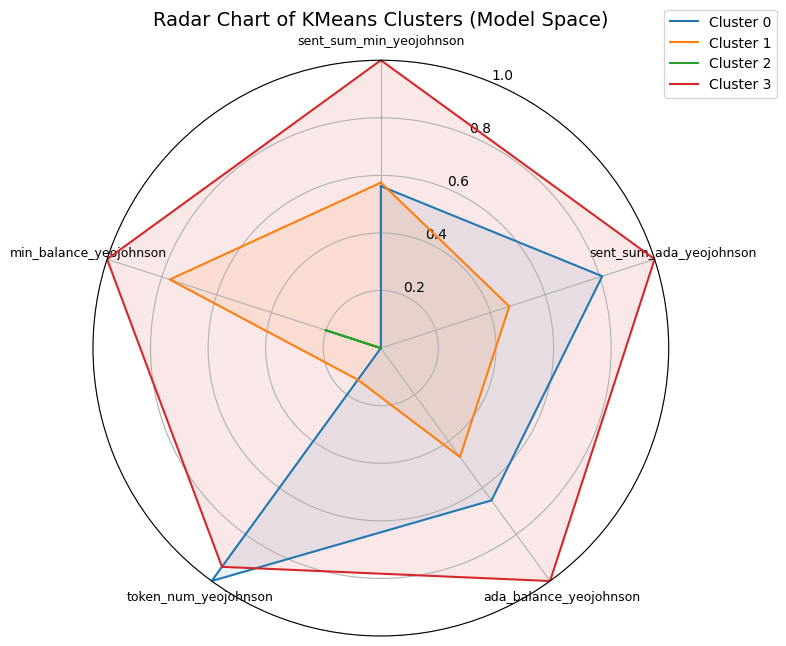

In [63]:
# ---- Use the exact same features and scaled data as clustering ----
# (These were used in your KMeans step)
# features = [...]  # the same list you used for X
# X_scaled already computed above
# kmeans_labels already computed above

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1) Put X_scaled back to a DataFrame aligned with labels
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=min_aggregated_holder_df.index)
X_scaled_df["kmeans_cluster"] = kmeans_labels

# 2) Cluster-wise means in the SAME (standardized) space as the model
cluster_summary_std = X_scaled_df.groupby("kmeans_cluster")[features].mean()

# 3) Min-max scale across clusters per feature ONLY for plotting (keeps shapes)
mm = MinMaxScaler()
cluster_scaled = mm.fit_transform(cluster_summary_std)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary_std.index)

# 4) Radar chart
num_vars = len(features)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

ax.set_title("Radar Chart of KMeans Clusters (Model Space)", size=14)
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Radar Chart of KMeans Clusters')

(<a list of 10 Line2D ticklines objects>,
 [Text(0.0, 0, 'sent_sum_min_yeojohnson'),
  Text(1.2566370614359172, 0, 'sent_sum_ada_yeojohnson'),
  Text(2.5132741228718345, 0, 'ada_balance_yeojohnson'),
  Text(3.7699111843077517, 0, 'token_num_yeojohnson'),
  Text(5.026548245743669, 0, 'min_balance_yeojohnson')])

(0.0, 1.0)

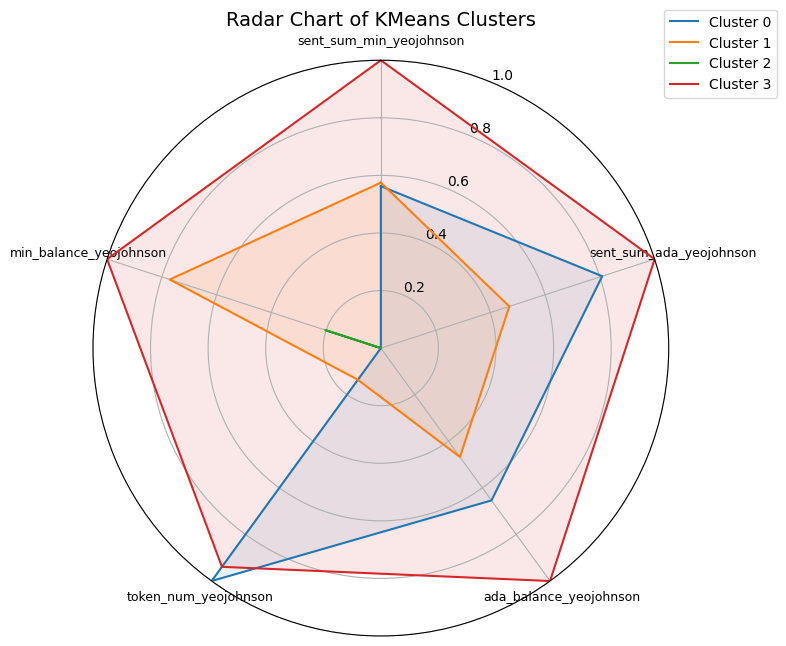

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Use updated feature list with Yeo-Johnson + raw count

features = [
    "sent_sum_min_yeojohnson", "sent_sum_ada_yeojohnson",
    "ada_balance_yeojohnson", "token_num_yeojohnson",
     "min_balance_yeojohnson",
]

# Step 2: Compute cluster-wise means
cluster_summary = min_aggregated_holder_df.groupby("kmeans_cluster")[features].mean()

# Step 3: Normalize each feature to [0, 1] for radar chart
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# Step 4: Set up radar chart angles
num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Step 5: Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

# Step 6: Styling
ax.set_title("Radar Chart of KMeans Clusters", size=14)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Radar Chart of MIN Holders')

(<a list of 10 Line2D ticklines objects>,
 [Text(0.0, 0, 'sent_sum_min_yeojohnson'),
  Text(1.2566370614359172, 0, 'sent_sum_ada_yeojohnson'),
  Text(2.5132741228718345, 0, 'ada_balance_yeojohnson'),
  Text(3.7699111843077517, 0, 'token_num_yeojohnson'),
  Text(5.026548245743669, 0, 'min_balance_yeojohnson')])

(0.0, 1.0)

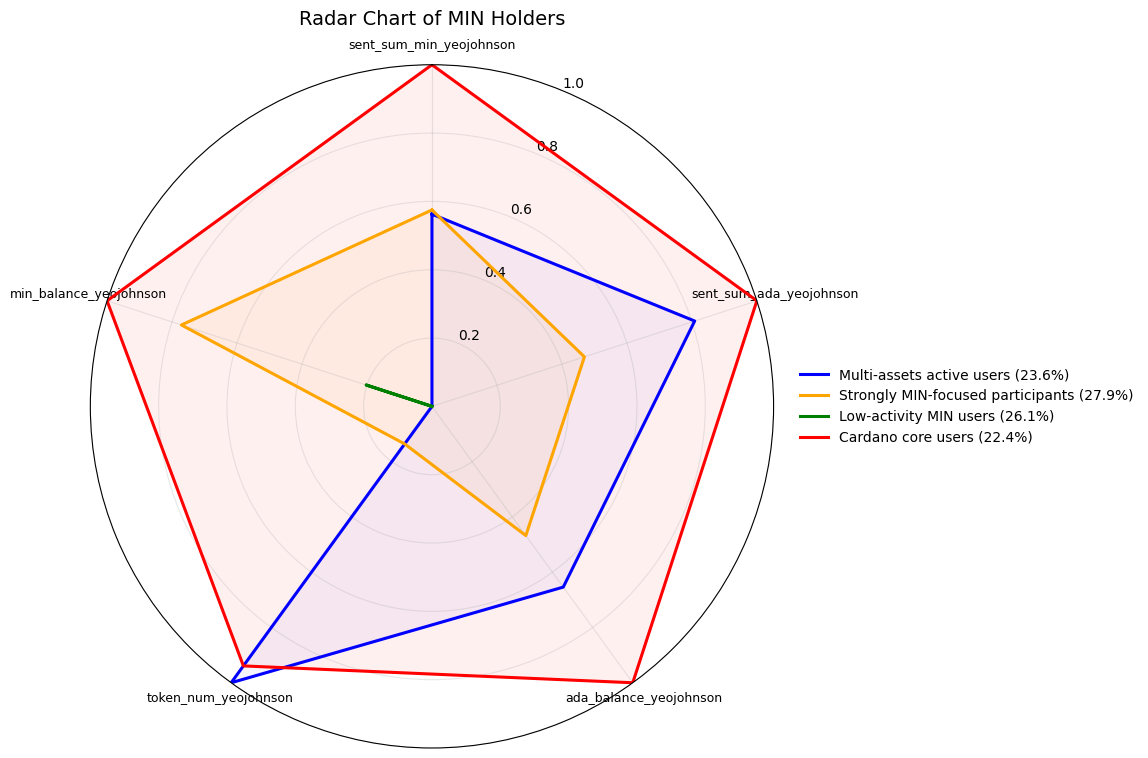

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Feature list (Yeo-Johnson + raw count) ---
features = [
    "sent_sum_min_yeojohnson", "sent_sum_ada_yeojohnson",
    "ada_balance_yeojohnson", "token_num_yeojohnson",
    "min_balance_yeojohnson",
]

# --- Cluster info: label, color, percentage ---
cluster_info = {
    3: ("Cardano core users", "red", 22.4),
    2: ("Low-activity MIN users", "green", 26.1),
    0: ("Multi-assets active users", "blue", 23.6),
    1: ("Strongly MIN-focused participants", "orange", 27.9),
}

# --- Compute cluster-wise means ---
cluster_summary = min_aggregated_holder_df.groupby("kmeans_cluster")[features].mean()

# --- Normalize for radar chart ---
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# --- Radar chart setup ---
num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close loop

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# --- Plot each cluster ---
for cid in cluster_scaled_df.index:
    if cid in cluster_info:
        values = cluster_scaled_df.loc[cid].tolist()
        values += values[:1]
        label, color, pct = cluster_info[cid]

        # Fill area with low alpha to avoid strong color blending
        fill_alpha = 0.06 if color != "blue" else 0.04  # blue gets even lighter fill
        ax.fill(angles, values, color=color, alpha=fill_alpha, zorder=1)

        # Plot outline on top
        ax.plot(
            angles, values,
            color=color,
            linewidth=2.2,
            zorder=2,
            label=f"{label} ({pct}%)"  # only group name + percentage
        )

# --- Styling ---
ax.set_title("Radar Chart of MIN Holders", size=14, pad=10)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Legend outside the chart
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Radar Chart of KMeans Clusters')

(<a list of 10 Line2D ticklines objects>,
 [Text(0.0, 0, 'sent_sum_min_yeojohnson'),
  Text(1.2566370614359172, 0, 'sent_sum_ada_yeojohnson'),
  Text(2.5132741228718345, 0, 'ada_balance_yeojohnson'),
  Text(3.7699111843077517, 0, 'token_num_yeojohnson'),
  Text(5.026548245743669, 0, 'min_balance_yeojohnson')])

(0.0, 1.0)

([<matplotlib.patches.Wedge at 0x7fbb22bda710>,
 [Text(-1.0988860986760365, -0.04949082881262375, 'Cluster 0'),
  Text(0.03895343154880263, -1.0993100700760332, 'Cluster 1'),
  Text(1.086116921977085, 0.17421260515537634, 'Cluster 2'),
  Text(-0.18461730234973292, 1.0843968146730731, 'Cluster 3')],
 [Text(-0.5993924174596562, -0.026994997534158405, '23.7%'),
  Text(0.021247326299346888, -0.5996236745869271, '26.0%'),
  Text(0.5924274119875008, 0.09502505735747799, '27.9%'),
  Text(-0.10070034673621796, 0.591489171639858, '22.4%')])

Text(0.5, 1.0, 'Distribution of Holders per Cluster')

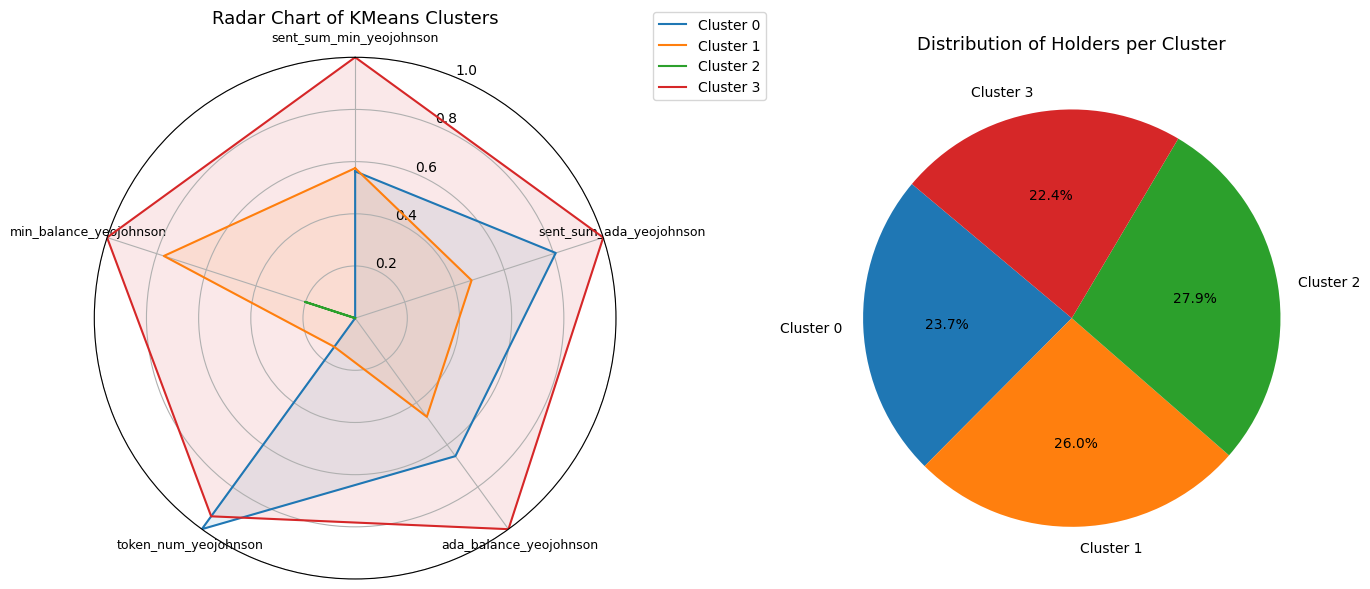

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Step 1: Define features
features = [
    "sent_sum_min_yeojohnson", 
    "sent_sum_ada_yeojohnson", 
    "ada_balance_yeojohnson", "token_num_yeojohnson",
    "min_balance_yeojohnson",
]

# Step 2: Cluster-wise means
cluster_summary = min_aggregated_holder_df.groupby("kmeans_cluster")[features].mean()

# Step 3: Normalize for radar chart
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# Step 4: Cluster counts for pie chart
cluster_counts = min_aggregated_holder_df["kmeans_cluster"].value_counts().sort_index()
labels = [f"Cluster {i}" for i in cluster_counts.index]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Step 5: Plot setup
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

# Create subplots manually
fig = plt.figure(figsize=(14, 6))

# Radar chart (left)
ax1 = plt.subplot(1, 2, 1, polar=True)
for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist() + row.tolist()[:1]
    ax1.plot(angles, values, label=f"Cluster {idx}", color=colors[idx])
    ax1.fill(angles, values, alpha=0.1, color=colors[idx])

ax1.set_title("Radar Chart of KMeans Clusters", size=13)
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)
ax1.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax1.set_ylim(0, 1)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Pie chart (right)
ax2 = plt.subplot(1, 2, 2)
ax2.pie(cluster_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax2.set_title("Distribution of Holders per Cluster", fontsize=13)

plt.tight_layout()
plt.show()


Text(-0.05, 2955.5, 'Cluster 0')

Text(-0.05, 9153.5, 'Cluster 1')

Text(-0.05, 15879.5, 'Cluster 2')

Text(-0.05, 22153.5, 'Cluster 3')

Text(0.5, 1.0, 'Silhouette Analysis for KMeans Clustering (k=4)')

Text(0.5, 0, 'Silhouette Coefficient Values')

Text(0, 0.5, 'Cluster Label')

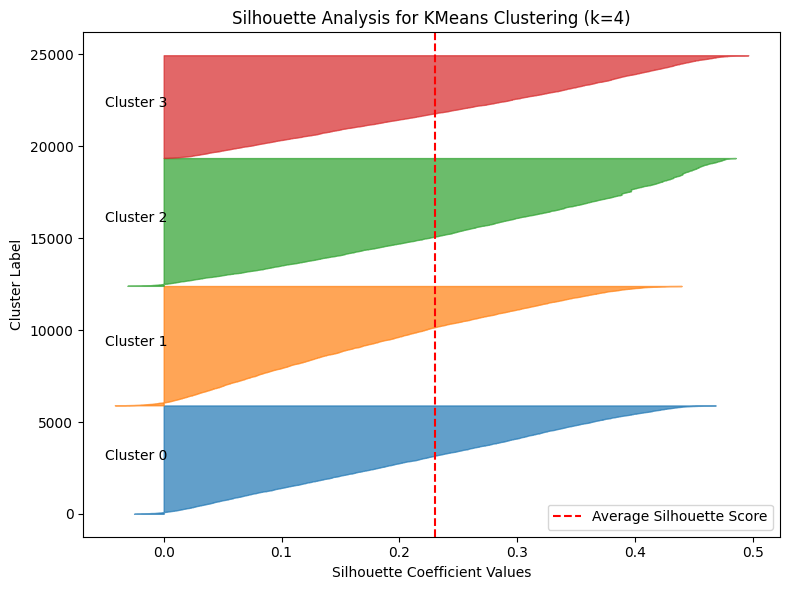

In [44]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Step 7: Compute silhouette values
cluster_labels = min_aggregated_holder_df["kmeans_cluster"]
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
avg_silhouette = silhouette_score(X_scaled, cluster_labels)

# Step 8: Plot Silhouette Analysis
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
n_clusters = len(np.unique(cluster_labels))

for i in range(n_clusters):
    ith_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_silhouette_values.sort()
    
    size_cluster_i = ith_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(i)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    
    y_lower = y_upper + 10  # Add space between clusters

# Step 9: Final formatting
ax.axvline(x=avg_silhouette, color="red", linestyle="--", label="Average Silhouette Score")
ax.set_title(f"Silhouette Analysis for KMeans Clustering (k={n_clusters})")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()


In [45]:
min_balance_stats = min_aggregated_holder_df.groupby("kmeans_cluster")["min_balance"].describe()
min_balance_stats

,count,mean,std,min,25%,50%,75%,max
kmeans_cluster,,,,,,,,
0,5891.000000,107.758333,274.287286,1.000000,9.025982,33.338325,100.000101,5000.001480
1,6485.000000,20921.142611,298622.026012,2.071661,355.569724,1286.147250,5380.607046,11990000.000000
2,6947.000000,4505.738018,138611.824560,1.000000,14.973595,60.000000,407.002411,10000000.000000
3,5581.000000,46982.533100,406247.875159,7.848035,1066.995862,4374.965936,17761.194419,23763044.000000


In [46]:
def gini(array):
    """Compute Gini coefficient of a numpy array."""
    array = array[~np.isnan(array)]  # remove NaNs
    if len(array) == 0:
        return np.nan
    sorted_arr = np.sort(array)
    n = len(array)
    cumvals = np.cumsum(sorted_arr)
    gini_coeff = (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n
    return gini_coeff


<Figure size 700x500 with 0 Axes>

<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Gini Coefficient per Cluster for min_balance')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Gini Coefficient')

(0.0, 1.0)

([<matplotlib.axis.XTick at 0x7fbb20c4aa90>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

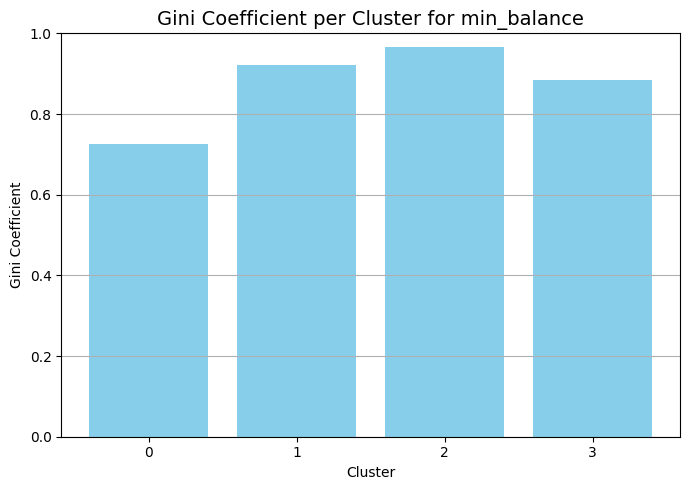

In [47]:
# === Gini plot after radar chart ===
target_variable = "min_balance"  # or 'ada_balance', 'tx_count' etc.

# Step 1: Compute Gini for each cluster
gini_per_cluster = {}
for c in sorted(min_aggregated_holder_df["kmeans_cluster"].unique()):
    group_vals = min_aggregated_holder_df.loc[
        min_aggregated_holder_df["kmeans_cluster"] == c, target_variable
    ].values
    gini_per_cluster[c] = gini(group_vals)

# Step 2: Plot Gini per cluster
plt.figure(figsize=(7, 5))
plt.bar(gini_per_cluster.keys(), gini_per_cluster.values(), color="skyblue")
plt.title(f"Gini Coefficient per Cluster for {target_variable}", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Gini Coefficient")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.xticks(list(gini_per_cluster.keys()))
plt.tight_layout()
plt.show()


<Figure size 700x500 with 0 Axes>

<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Gini Coefficient per Cluster for ada_balance')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Gini Coefficient')

(0.0, 1.0)

([<matplotlib.axis.XTick at 0x7fbb20cb59d0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

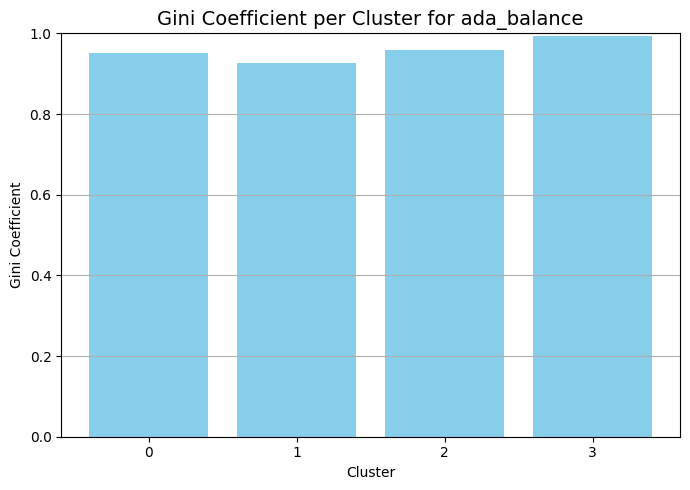

In [48]:
# === Gini plot after radar chart ===
target_variable = "ada_balance"  # or 'ada_balance', 'tx_count' etc.

# Step 1: Compute Gini for each cluster
gini_per_cluster = {}
for c in sorted(min_aggregated_holder_df["kmeans_cluster"].unique()):
    group_vals = min_aggregated_holder_df.loc[
        min_aggregated_holder_df["kmeans_cluster"] == c, target_variable
    ].values
    gini_per_cluster[c] = gini(group_vals)

# Step 2: Plot Gini per cluster
plt.figure(figsize=(7, 5))
plt.bar(gini_per_cluster.keys(), gini_per_cluster.values(), color="skyblue")
plt.title(f"Gini Coefficient per Cluster for {target_variable}", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Gini Coefficient")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.xticks(list(gini_per_cluster.keys()))
plt.tight_layout()
plt.show()


In [49]:
from scipy.stats import f_oneway
import pandas as pd

f_stats = {}
p_values = {}

for feature in features:
    groups = [min_aggregated_holder_df[min_aggregated_holder_df['kmeans_cluster'] == c][feature] 
              for c in sorted(min_aggregated_holder_df['kmeans_cluster'].unique())]
    
    f_val, p_val = f_oneway(*groups)
    f_stats[feature] = f_val
    p_values[feature] = p_val

anova_df = pd.DataFrame({
    "F-statistic": f_stats,
    "p-value": p_values
}).round(4)

anova_df


,F-statistic,p-value
sent_sum_min_yeojohnson,10570.693400,0.000000
sent_sum_ada_yeojohnson,13430.050300,0.000000
ada_balance_yeojohnson,7465.984800,0.000000
token_num_yeojohnson,10130.108800,0.000000
min_balance_yeojohnson,7911.699900,0.000000


# HDBSCAN

In [50]:
!pip install hdbscan


In [51]:
import hdbscan
import pandas as pd
import numpy as np

results = []

# Define grid
min_cluster_sizes = [30, 50, 70, 100]
min_samples_list = [5, 10, 15, 20]

# Grid search
for mcs in min_cluster_sizes:
    for ms in min_samples_list:
        try:
            hdb = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
            labels = hdb.fit_predict(X_scaled)
            num_total = len(labels)
            num_noise = np.sum(labels == -1)
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_ratio = num_noise / num_total
            results.append({
                "min_cluster_size": mcs,
                "min_samples": ms,
                "num_clusters": num_clusters,
                "noise_points": num_noise,
                "noise_ratio": round(noise_ratio, 4)
            })
        except Exception as e:
            print(f"❌ Failed for mcs={mcs}, ms={ms}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="noise_ratio")

# Show best 10 results
results_df.head()

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11

,min_cluster_size,min_samples,num_clusters,noise_points,noise_ratio
12,100,5,9,14707,0.590500
4,50,5,14,14730,0.591500
0,30,5,17,14751,0.592300
8,70,5,11,14914,0.598900
9,70,10,9,15265,0.613000


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 HDBSCAN Clustering Result:
hdbscan_cluster
-1    14707
 0      495
 1      438
 2      419
 3     7050
 4      183
 5      894
 6      137
 7      117
 8      464
Name: count, dtype: int64
❌ Noise points: 14707/24904 (59.05%)


Text(0.5, 1.0, 'Radar Chart of HDBSCAN Clusters')

(<a list of 10 Line2D ticklines objects>,
 [Text(0.0, 0, 'sent_sum_min_yeojohnson'),
  Text(1.2566370614359172, 0, 'sent_sum_ada_yeojohnson'),
  Text(2.5132741228718345, 0, 'ada_balance_yeojohnson'),
  Text(3.7699111843077517, 0, 'token_num_yeojohnson'),
  Text(5.026548245743669, 0, 'min_balance_yeojohnson')])

(0.0, 1.0)

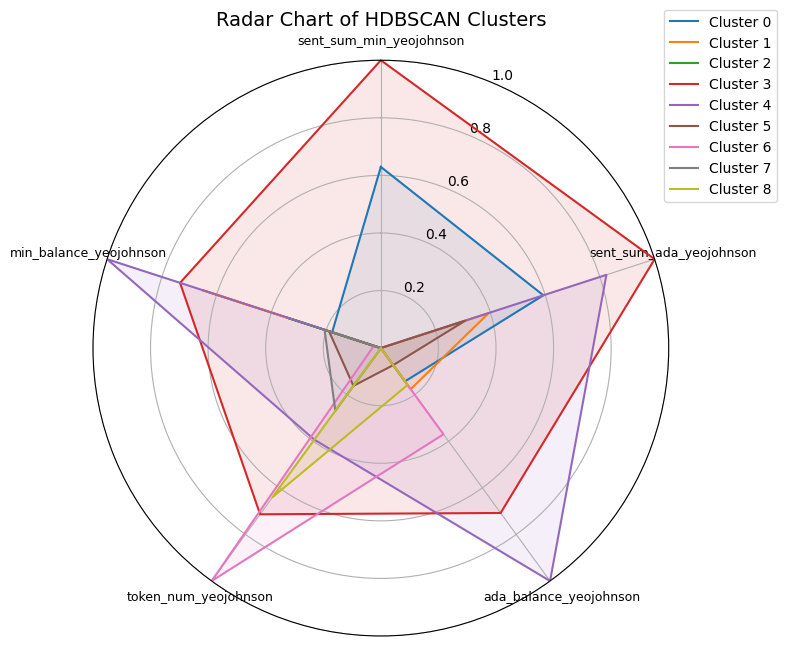

In [53]:
# Step 0: Install if needed
# !pip install hdbscan

import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# === Step 1: Run HDBSCAN ===
hdb = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=5)
hdb_labels = hdb.fit_predict(X_scaled)

# Save to df
min_aggregated_holder_df["hdbscan_cluster"] = hdb_labels

# Print label count
print("📊 HDBSCAN Clustering Result:")
print(min_aggregated_holder_df["hdbscan_cluster"].value_counts().sort_index())

# Print noise rate
noise_count = (hdb_labels == -1).sum()
total = len(hdb_labels)
print(f"❌ Noise points: {noise_count}/{total} ({noise_count/total:.2%})")

# === Step 2: Radar Chart of Cluster Means ===
features = [
    "sent_sum_min_yeojohnson", 
    "sent_sum_ada_yeojohnson", 
    "ada_balance_yeojohnson", "token_num_yeojohnson",
    "min_balance_yeojohnson",
]

# Filter out noise points
clustered_df = min_aggregated_holder_df[min_aggregated_holder_df["hdbscan_cluster"] != -1]

# Compute mean per cluster
cluster_summary = clustered_df.groupby("hdbscan_cluster")[features].mean()
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# Radar plot
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

ax.set_title("Radar Chart of HDBSCAN Clusters", size=14)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

In [54]:
cluster_summary_table = clustered_df.groupby("hdbscan_cluster")[features].mean()
cluster_summary_table

,sent_sum_min_yeojohnson,sent_sum_ada_yeojohnson,ada_balance_yeojohnson,token_num_yeojohnson,min_balance_yeojohnson
hdbscan_cluster,,,,,
0,6.067556,7.808996,1.453420,0.645938,4.244551
1,0.000581,5.184363,1.559271,0.645938,5.676137
2,0.000000,0.014500,1.003664,0.645938,4.735753
3,9.638388,13.153056,3.234705,2.130911,5.918447
4,0.004443,10.835968,4.155423,1.463973,6.721460
5,0.002481,4.052589,1.233933,0.983177,4.278360
6,0.000000,0.000000,2.170200,2.727086,3.785998
7,0.000000,0.007327,1.005379,1.205934,4.327624
8,0.000000,0.001738,1.502284,1.977449,3.708387


Text(-0.05, 257.5, 'Cluster 0')

Text(-0.05, 734.0, 'Cluster 1')

Text(-0.05, 1172.5, 'Cluster 2')

Text(-0.05, 4917.0, 'Cluster 3')

Text(-0.05, 8543.5, 'Cluster 4')

Text(-0.05, 9092.0, 'Cluster 5')

Text(-0.05, 9617.5, 'Cluster 6')

Text(-0.05, 9754.5, 'Cluster 7')

Text(-0.05, 10055.0, 'Cluster 8')

Text(0.5, 1.0, 'Silhouette Analysis for HDBSCAN Clustering (Excl. Noise)')

Text(0.5, 0, 'Silhouette Coefficient Values')

Text(0, 0.5, 'Cluster Label')

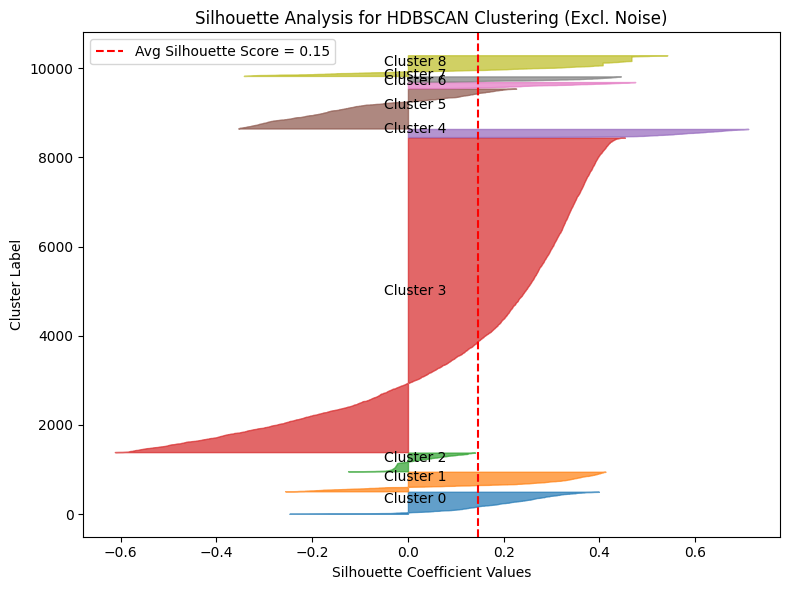

In [55]:
from sklearn.metrics import silhouette_samples, silhouette_score

# === Step 3: Silhouette Plot ===

# Filter X and labels to only clustered points (exclude noise)
X_clustered = X_scaled[min_aggregated_holder_df["hdbscan_cluster"] != -1]
labels_clustered = min_aggregated_holder_df.loc[min_aggregated_holder_df["hdbscan_cluster"] != -1, "hdbscan_cluster"]

# Compute silhouette values
sil_values = silhouette_samples(X_clustered, labels_clustered)
avg_sil = silhouette_score(X_clustered, labels_clustered)

# Start plotting
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
unique_clusters = np.sort(labels_clustered.unique())

for i in unique_clusters:
    ith_sil_vals = sil_values[labels_clustered == i]
    ith_sil_vals.sort()
    
    size = ith_sil_vals.shape[0]
    y_upper = y_lower + size

    color = plt.cm.tab10(i % 10)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size, f"Cluster {i}")
    y_lower = y_upper + 10

ax.axvline(x=avg_sil, color='red', linestyle='--', label=f"Avg Silhouette Score = {avg_sil:.2f}")
ax.set_title(f"Silhouette Analysis for HDBSCAN Clustering (Excl. Noise)")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()


In [56]:
# Step 4: Count the number of holders in each HDBSCAN cluster (excluding noise)

# Filter out noise points
non_noise_df = min_aggregated_holder_df[min_aggregated_holder_df["hdbscan_cluster"] != -1]

# Group by HDBSCAN cluster and count the number of unique holders
hdbscan_cluster_counts = non_noise_df.groupby("hdbscan_cluster")["final_holder_id"] \
    .nunique() \
    .reset_index(name="holder_count")

# Calculate total holders
total_holders = hdbscan_cluster_counts["holder_count"].sum()

# Add percentage column with % format
hdbscan_cluster_counts["percentage"] = hdbscan_cluster_counts["holder_count"] \
    .apply(lambda x: f"{(x / total_holders * 100):.2f}%")

# Sort by cluster ID
hdbscan_cluster_counts = hdbscan_cluster_counts.sort_values("hdbscan_cluster").reset_index(drop=True)

# Display the result
print("Number and percentage of holders per HDBSCAN cluster:")
display(hdbscan_cluster_counts)


Number and percentage of holders per HDBSCAN cluster:


,hdbscan_cluster,holder_count,percentage
0,0,495,4.85%
1,1,438,4.30%
2,2,419,4.11%
3,3,7050,69.14%
4,4,183,1.79%
5,5,894,8.77%
6,6,137,1.34%
7,7,117,1.15%
8,8,464,4.55%


# GMM

Text(0.5, 1.0, 'Silhouette Score vs. Number of Components (GMM)')

Text(0.5, 0, 'Number of Components (k)')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'BIC vs. Number of Components (GMM)')

Text(0.5, 0, 'Number of Components (k)')

Text(0, 0.5, 'BIC Score')

Text(0.5, 1.0, 'AIC vs. Number of Components (GMM)')

Text(0.5, 0, 'Number of Components (k)')

Text(0, 0.5, 'AIC Score')

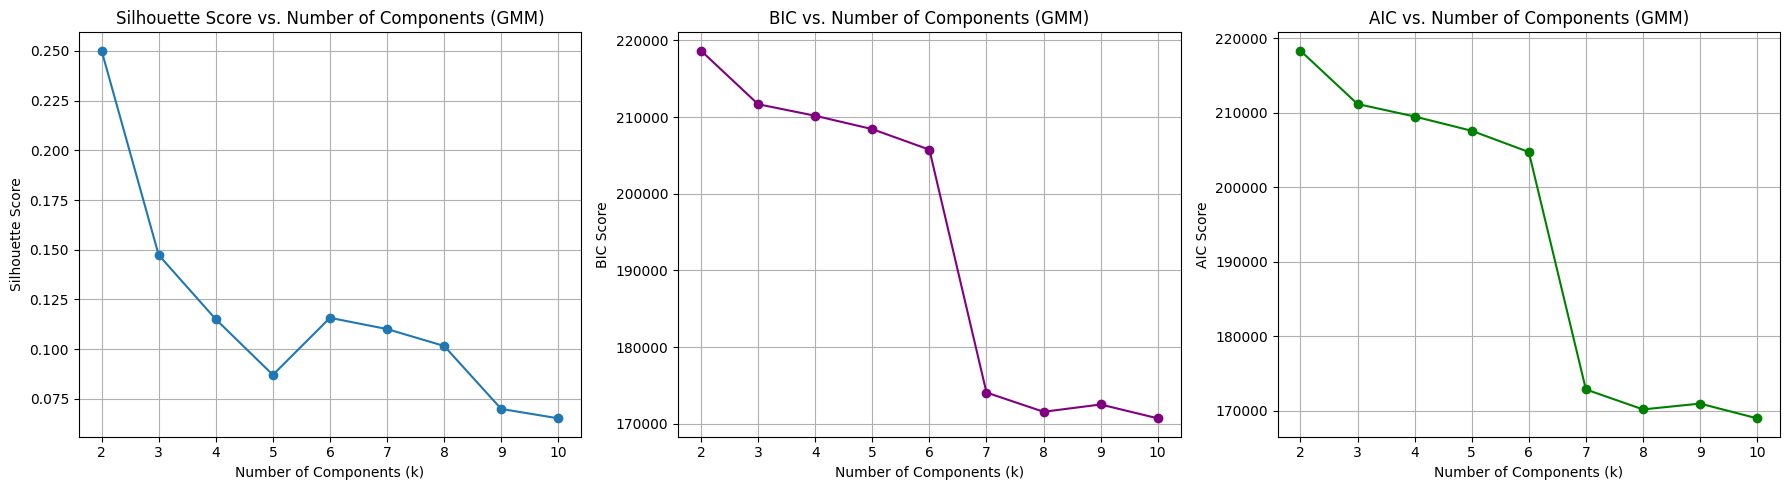

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 1: Extract and standardize the selected features
X = min_aggregated_holder_df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Initialize result containers
silhouette_scores = []
bic_scores = []
aic_scores = []
k_range = range(2, 11)

# Step 3: Loop over possible k values to evaluate clustering quality
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)

    # Scores
    sil_score = silhouette_score(X_scaled, labels)
    bic_score = gmm.bic(X_scaled)
    aic_score = gmm.aic(X_scaled)

    silhouette_scores.append(sil_score)
    bic_scores.append(bic_score)
    aic_scores.append(aic_score)

# Step 4: Plot Silhouette, BIC, AIC side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score plot
ax1.plot(k_range, silhouette_scores, marker='o')
ax1.set_title("Silhouette Score vs. Number of Components (GMM)")
ax1.set_xlabel("Number of Components (k)")
ax1.set_ylabel("Silhouette Score")
ax1.grid(True)

# BIC plot (lower is better)
ax2.plot(k_range, bic_scores, marker='o', color='purple')
ax2.set_title("BIC vs. Number of Components (GMM)")
ax2.set_xlabel("Number of Components (k)")
ax2.set_ylabel("BIC Score")
ax2.grid(True)

# AIC plot (lower is better)
ax3.plot(k_range, aic_scores, marker='o', color='green')
ax3.set_title("AIC vs. Number of Components (GMM)")
ax3.set_xlabel("Number of Components (k)")
ax3.set_ylabel("AIC Score")
ax3.grid(True)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Radar Chart of GMM Clusters (k=4)')

(<a list of 10 Line2D ticklines objects>,
 [Text(0.0, 0, 'sent_sum_min_yeojohnson'),
  Text(1.2566370614359172, 0, 'sent_sum_ada_yeojohnson'),
  Text(2.5132741228718345, 0, 'ada_balance_yeojohnson'),
  Text(3.7699111843077517, 0, 'token_num_yeojohnson'),
  Text(5.026548245743669, 0, 'min_balance_yeojohnson')])

(0.0, 1.0)

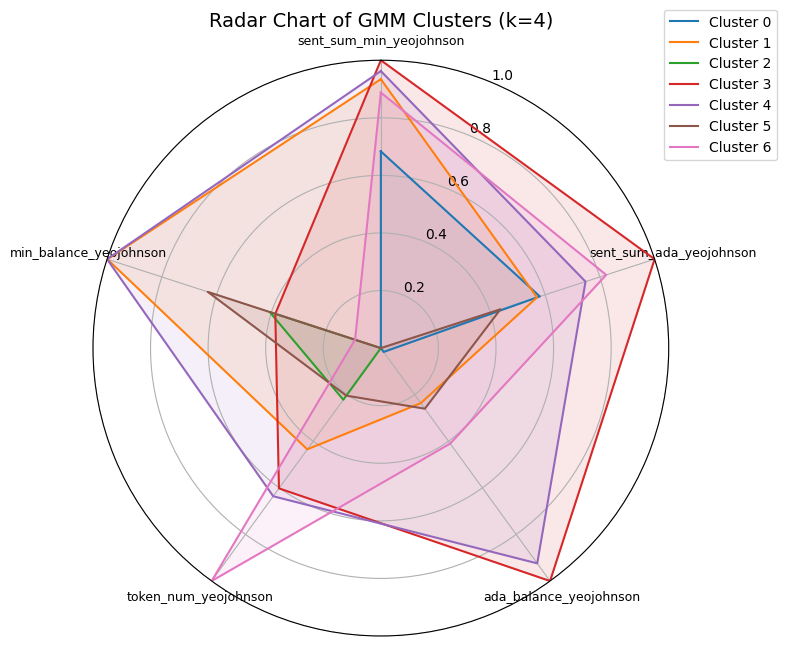

In [59]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fit GMM with k=7
gmm_final = GaussianMixture(n_components=7, random_state=42)
min_aggregated_holder_df["gmm_cluster"] = gmm_final.fit_predict(X_scaled)

# Step 2: Compute feature means per cluster
features = [
    "sent_sum_min_yeojohnson", 
    "sent_sum_ada_yeojohnson", 
    "ada_balance_yeojohnson", "token_num_yeojohnson",
"min_balance_yeojohnson",
]

cluster_summary = min_aggregated_holder_df.groupby("gmm_cluster")[features].mean()

# Step 3: Normalize values for radar plot
scaler = MinMaxScaler()
cluster_scaled = scaler.fit_transform(cluster_summary)
cluster_scaled_df = pd.DataFrame(cluster_scaled, columns=features, index=cluster_summary.index)

# Step 4: Radar chart
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in cluster_scaled_df.iterrows():
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

ax.set_title("Radar Chart of GMM Clusters (k=4)", size=14)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=9)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


Text(-0.05, 1269.5, 'Cluster 0')

Text(-0.05, 5589.0, 'Cluster 1')

Text(-0.05, 9973.0, 'Cluster 2')

Text(-0.05, 11862.0, 'Cluster 3')

Text(-0.05, 14587.0, 'Cluster 4')

Text(-0.05, 18772.0, 'Cluster 5')

Text(-0.05, 22885.5, 'Cluster 6')

Text(0.5, 1.0, 'Silhouette Analysis for GMM Clustering (k=7)')

Text(0.5, 0, 'Silhouette Coefficient Values')

Text(0, 0.5, 'Cluster Label')

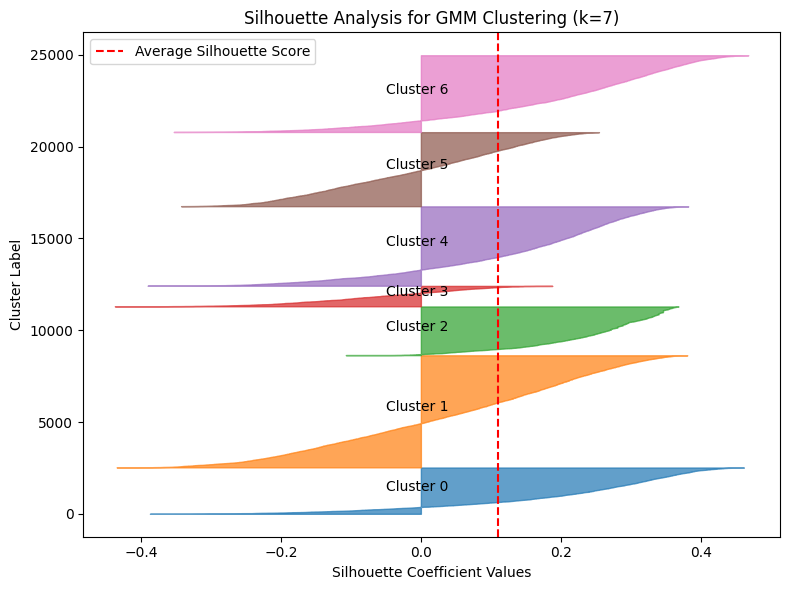

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Step 7: Compute silhouette values
cluster_labels = min_aggregated_holder_df["gmm_cluster"]  
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
avg_silhouette = silhouette_score(X_scaled, cluster_labels)

# Step 8: Plot Silhouette Analysis
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
n_clusters = len(np.unique(cluster_labels))

for i in range(n_clusters):
    ith_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_silhouette_values.sort()
    
    size_cluster_i = ith_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(i)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    
    y_lower = y_upper + 10

# Step 9: Final formatting
ax.axvline(x=avg_silhouette, color="red", linestyle="--", label="Average Silhouette Score")
ax.set_title(f"Silhouette Analysis for GMM Clustering (k={n_clusters})") 
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()
